In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

In [62]:
import keras
eps = 1e-8
class fast_queue(keras.callbacks.Callback):
    def __init__(self, size):
        self.data = [None] * (size + 1)
        self.sam_loss = np.array([0.] * (size + 1))
        self.indice = list(range(0, size + 1))
        self.filled = False
        
        # state index (training)
        self.idx = 0


        self.size = size + 1
        self.start = 0
        self.end = 0

    def __get__(self, obj, objtype):
        if self.start <= self.end:
            print([self[x] for x in range(self.start, self.end)])
        else:
            print([self[x] for x in range(self.start, self.end + self.size)])

    def __len__(self):
        if self.start <= self.end:
            return self.end - self.start
        else:
            return self.size + self.end - self.start

    def __getitem__(self, idx):
        return self.data[(self.start + idx) % self.size]
    
    def get_loss(self, idx):
        return self.sam_loss[(self.start + idx) % self.size]

    def random_batch(self, sample_num):
        # Return index list
        # Prioritize higher loss sample (Prioritized Replay)
        return np.random.choice(self.indice, sample_num, replace=False, p = self.sam_loss/self.sam_loss.sum())
    
    def random_unweight_batch(self, sample_num):
        
        if self.filled:
            return np.random.choice(self.indice, sample_num)
        else:
            return np.random.choice(list(range(self.end)), sample_num)
    
    def on_batch_end(self, batch, logs={}):
        # Keras callback
        self.loss = logs.get('loss')
        print(self.loss)

    def save_loss(self, idx):
        self.sam_loss[(self.start + idx) % self.size] = self.loss

    def append(self, item):
        self.data[self.end] = item
        self.sam_loss[self.end] = eps
        self.end = (self.end + 1) % self.size

        if self.start == self.end:
            self.filled = True
            self.sam_loss[self.start] = 0.
            self.start = (self.start + 1) % self.size

In [64]:
from collections import deque
import random
import sys

sys.path.append('../../')
sys.path.append('game/')

import numpy as np

from base_network import BaseNetwork
from keras.models import load_model
from snake_env import SnakeEnvironment

EP = 100000

class Config:
    height = 30
    width = 30
    action_num = 5
    lr = 3e-5
    eps = 1.
    eps_min = 0.1
    eps_decay = 0.999
    gamma = 0.95

class DQAgent():
    def __init__(self, config):
        self.config = config
        self.memory = fast_queue(5000)

        # model
        self.q = BaseNetwork(config.height, config.width, config.action_num, config) 
        # target model
        self.qt = BaseNetwork(config.height, config.width, config.action_num, config)


    def act(self, state):
        if random.uniform(0, 1) < self.config.eps:
            return random.randrange(self.config.action_num)
        else:
            print('predict')
            return np.argmax(self.q.model.predict(self.rescale_color(state))[0])

    def replay(self, batch_size):
        print('do_replay')
        if batch_size > len(self.memory):
            return
        if random.random() < 0.5:
            batch_indice = self.memory.random_batch(batch_size)
        else:
            batch_indice = self.memory.random_unweight_batch(batch_size)
        loss_batch = [self.memory.get_loss(x) for x in batch_indice]
        print(loss_batch)
        minibatch = [self.memory[x] for x in batch_indice]
        states = []
        targets = []
        for idx, (state, action, reward, next_state, done) in enumerate(minibatch):
            #print(state, action, reward, next_state, done)
            inpu = self.rescale_color(state)
            target = self.q.model.predict(inpu)
            if done:
                target[0][action] = reward
            else:
                inp = self.rescale_color(next_state)
                t = self.qt.model.predict(inp)[0]
                target[0][action] = reward + self.config.gamma * np.max(t)
                
            if done:
                print('died!:')
            self.q.model.fit(inpu, target, epochs=1, verbose=0, callbacks=[self.memory])
            self.memory.save_loss(batch_indice[idx])
        if self.config.eps > self.config.eps_min:
            self.config.eps *= self.config.eps_decay
        

    def rescale_color(self, state):
        return state / 3.
        

    def copy_param(self):
        self.qt.model.set_weights(self.q.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def save_model(self, path):
        self.q.model.save(path)
    
    def load_model(self, path):
        self.q.model = load_model(path)

def train():
    config = Config()
    env = SnakeEnvironment(config.width, config.height)
    agent = DQAgent(config)

    done = False
    batch_size = 32

    agent.copy_param()

    for i in range(EP):
        state = env.reset()
        
        state = np.expand_dims(state, axis=0)
        state = np.stack([state for _ in range(2)], axis=-1)
        #print(state.shape)
        done = False
        point = 0
        for t in range(5000):
            action = agent.act(state)
            tmp_state, reward, done = env.act(action)

            next_state = np.roll(state, -1, axis=-1)
            next_state[:,:,:,-1] = tmp_state

            point += reward

            agent.remember(state, action, reward, next_state, done)
            state = next_state.copy()
            if done:
                print('episode {}/{}, score: {}'.format(i, EP, point))

                # Print counted frames
                print(t)
                agent.copy_param()
                break
            
        agent.replay(batch_size)
        if i % 100 == 0:
            agent.save_model('model/snake.h5')

In [65]:
train()

episode 0/100000, score: -5
12
do_replay
episode 1/100000, score: -5
18
do_replay
[1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08]
0.00034593232
died!:
0.89834625
0.00030488527
0.00036448953
2.9982935e-05
2.7937445e-05
2.6645761e-05
1.1344212e-06
9.55115e-07
2.5341575e-05
8.126832e-07
6.598274e-07
0.00029857497
2.4365669e-05
2.4062412e-05
4.1427998e-07
0.0005555206
3.1077263e-07
0.00035744926
2.3006154e-07
0.00028795717
2.2208113e-05
0.00034766068
1.9978357e-05
1.7815146e-05
1.644474e-05
1.6378737e-05
0.00027787013
1.5511065e-05
0.00033737934
1.3537717e-05
died!:
0.8949505
episode 2/100000, score: -5
7
do_replay
[0.00034593231976032257, 2.534157465561293e-05, 3.1077263429324375e-07, 1e-08, 0.0002778701309580356, 8.126831971821957e-07, 1.5511064702877775e-05, 4.142799809869757e-07, 0.0005555205862037838, 2.5341574

0.00041594185
0.0004118231
0.00040809717
6.931104e-05
0.0003993846
6.6048306e-05
0.00038708583
6.532004e-05
0.0003798578
6.280225e-05
0.00037786065
0.00039901616
6.1789295e-05
0.0003975351
5.871822e-05
5.8798898e-05
predict
episode 9/100000, score: -5
51
do_replay
[0.8961812257766724, 0.9084962010383606, 0.8959898948669434, 0.8956300616264343, 0.00040809717029333115, 0.00038704948383383453, 0.00011882973922183737, 0.0004118231008760631, 0.00038813386345282197, 0.00039938458940014243, 0.0004178989620413631, 0.0003778606478590518, 0.00039388806908391416, 0.000387085834518075, 0.0004190129693597555, 0.00039901616401039064, 0.0004159418458584696, 0.0004225598240736872, 0.0003975350991822779, 6.532004044856876e-05, 5.8718218497233465e-05, 6.931104144314304e-05, 0.0003798578109126538, 0.00019610440358519554, 6.28022535238415e-05, 0.0003911472740583122, 0.00042158138239756227, 6.604830559808761e-05, 7.824618660379201e-05, 7.079070201143622e-05, 6.178929470479488e-05, 0.0003967702796217054]
di

0.0002637399
0.00020403916
0.00020418022
0.00026559664
0.00019944175
0.00019820435
0.00026422556
0.000259243
0.00019923435
0.00026117705
0.00025834457
0.00019877928
0.00019699021
0.00025693682
0.00025252724
0.00019584267
0.0002502069
0.0001950383
1.9766449e-07
episode 17/100000, score: -5
34
do_replay
[4.7414056325578713e-07, 2.8229186455064337e-07, 3.2791325565995066e-07, 0.00022698219981975853, 1e-08, 1e-08, 1e-08, 1e-08, 1.0053928235720377e-05, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 0.00033899248228408396, 1e-08, 0.0003492330142762512, 5.451072411233326e-06, 1e-08, 1e-08, 1e-08, 8.665500672577764e-08, 3.131874564132886e-07, 1e-08]
2.2707096e-07
1.2648193e-05
2.0724676e-07
0.00016812542
0.00022261412
2.2419586e-07
2.549018e-07
0.00016218463
7.643072e-07
1.377633e-05
2.2258561e-07
5.088983e-07
0.00021686617
0.00016119212
0.00015795002
2.5587815e-07
3.2913135e-07
2.4600226e-07
0.00021412424
0.00015890753
1.4759238e-05
0.00015247954
0.

7.592113e-05
8.4699906e-08
5.667793e-06
2.8700592e-06
5.835811e-06
1.0375926e-07
7.297956e-05
7.172074e-05
4.2816635e-05
died!:
0.9021476
2.0146035e-07
4.4929213e-05
7.0178285e-05
5.872327e-06
2.3482042e-07
6.002575e-06
2.4693628e-07
6.0369584e-06
4.3658052e-05
5.74574e-06
6.8915855e-05
2.6557126e-07
5.996322e-06
6.250585e-06
predict
episode 26/100000, score: -5
20
do_replay
[0.9021245241165161, 0.9024925231933594, 0.8976513743400574, 0.8980170488357544, 0.9021475911140442, 0.8996602892875671, 0.9043277502059937, 0.9035466313362122, 0.9023977518081665, 0.9027366638183594, 0.8991835713386536, 0.0002040391555055976, 0.0001589075254742056, 0.00015750616148579866, 0.00016812542162369937, 0.00015247953706420958, 0.00011604093015193939, 7.592113252030686e-05, 0.00011169527715537697, 0.00011682118201861158, 4.365805216366425e-05, 0.00010716488031903282, 7.172073674155399e-05, 4.573405021801591e-05, 0.00016181713726837188, 0.00010729538917075843, 0.00010996471246471629, 0.0002168661740142852, 

0.8969089
died!:
0.8994468
died!:
0.89969254
died!:
0.8990534
died!:
0.89620316
died!:
0.8987578
died!:
0.89918315
died!:
0.8960045
died!:
0.899864
died!:
0.89891183
died!:
0.89895374
died!:
0.89976823
died!:
0.8986942
died!:
0.89861214
died!:
0.8992693
5.2730475e-06
5.030091e-06
3.6337216e-05
5.4411566e-06
5.287603e-06
3.714882e-05
3.5576337e-05
4.860273e-06
3.6089124e-05
5.4335783e-06
5.328987e-06
5.017134e-06
5.344961e-06
3.547539e-05
5.123125e-06
6.4327787e-06
5.2522714e-06
predict
predict
episode 35/100000, score: -5
52
do_replay
[0.8986121416091919, 0.8991831541061401, 0.8998640179634094, 0.8986942172050476, 0.8989118337631226, 0.8997682332992554, 0.8989537358283997, 0.8990533947944641, 0.8960044980049133, 0.8994467854499817, 0.898757815361023, 0.8996925354003906, 0.8992692828178406, 0.8969088792800903, 0.8962031602859497, 1.4642762835137546e-05, 0.0001992343459278345, 5.973337101750076e-05, 1.924473326653242e-05, 0.00011295983858872205, 3.7984413211233914e-05, 7.05657439539209e-

2.2558512e-05
2.2666993e-05
predict
predict
episode 42/100000, score: -5
82
do_replay
[0.8932369351387024, 0.8933609127998352, 0.8926577568054199, 0.8927664756774902, 0.8915257453918457, 0.894553542137146, 0.8919986486434937, 0.8932094573974609, 0.8927653431892395, 0.8925091028213501, 0.8922417759895325, 0.8932141065597534, 0.893851101398468, 0.8939588665962219, 0.8943458795547485, 6.68592338115559e-06, 7.947901758598164e-05, 6.891585508128628e-05, 2.37179447140079e-05, 2.6307074222131632e-05, 3.4883116313721985e-05, 3.422538429731503e-05, 7.228960021166131e-05, 6.358347309287637e-05, 3.9070317143341526e-05, 8.399851139984094e-06, 8.513205102644861e-05, 6.401898281183094e-05, 2.4100821974570863e-05, 5.996322215651162e-06, 3.219619611627422e-05, 6.9438783611985855e-06]
died!:
0.8917491
died!:
0.8928949
died!:
0.89127386
died!:
0.89210624
died!:
0.89073646
died!:
0.891955
died!:
0.8906805
died!:
0.8916804
died!:
0.89000237
died!:
0.8913604
died!:
0.8896219
died!:
0.89167434
died!:
0.8910

3.0519484e-05
3.9643837e-05
1.3314433e-05
0.000108505636
episode 50/100000, score: -5
13
do_replay
[0.8872518539428711, 0.8830140233039856, 0.887954592704773, 0.8878766298294067, 0.8860214352607727, 0.8864935636520386, 0.8863989114761353, 0.8840596079826355, 0.8867994546890259, 0.8868036270141602, 0.8836530447006226, 0.8853333592414856, 0.8871995210647583, 0.8868080377578735, 0.8886321187019348, 0.8884580731391907, 0.8873690366744995, 1.2042398793710163e-06, 1.6196765955101e-06, 2.044662778644124e-06, 4.559597800835036e-05, 7.653028660570271e-06, 1.3589997251983732e-05, 2.084019433823414e-05, 6.574602593900636e-06, 1.942172457347624e-05, 1.978745603992138e-05, 2.3152253561420366e-05, 9.07879148144275e-05, 8.264088137366343e-06, 7.81298876972869e-05, 2.262626549054403e-05]
died!:
0.88523626
died!:
0.882518
died!:
0.8856484
died!:
0.88636094
died!:
0.88448524
died!:
0.8859059
died!:
0.8850252
died!:
0.88142854
died!:
0.8843644
died!:
0.88386375
died!:
0.88074523
died!:
0.8803115
died!:
0

6.153794e-06
1.5144451e-06
1.026659e-06
4.9601913e-06
4.870582e-05
1.0347948e-05
1.7616323e-06
1.2144769e-06
1.1908251e-06
4.1484975e-05
predict
predict
episode 58/100000, score: -5
39
do_replay
[1e-08, 1e-08, 1e-08, 1e-08, 1.3619049354929302e-07, 1e-08, 1e-08, 1e-08, 2.1536301574087702e-05, 1e-08, 1.775277269189246e-06, 1e-08, 9.361081174574792e-05, 1.1144444442834356e-06, 1e-08, 1e-08, 1e-08, 1e-08, 3.6324804568721447e-06, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 7.684461706958245e-06, 1e-08, 1e-08, 1.5911139144009212e-06, 1e-08, 1e-08, 1e-08, 1e-08]
died!:
0.87515306
2.4892686e-05
died!:
0.87880623
1.4807413e-05
4.806894e-05
1.36555045e-05
died!:
0.8760723
7.500294e-05
2.4994826e-05
0.00012663846
1.7485818e-05
7.317297e-05
7.145909e-05
1.7087074e-05
1.2067878e-05
6.782335e-05
1.1146809e-05
1.0046318e-05
2.3132085e-05
0.00011834728
9.125497e-06
0.00012013015
8.308355e-06
6.895138e-05
1.604259e-05
0.000113323054
2.1506594e-05
7.263649e-06
0.00011063447
0.0001098732
0.0001051776
1.4147474e-0

died!:
0.86124545
died!:
0.86603564
died!:
0.86551285
died!:
0.86494714
died!:
0.86443645
died!:
0.8602394
died!:
0.8595725
died!:
0.8639072
0.00051716366
0.00011107455
0.0004018192
0.00051531143
0.00038735196
0.0005102432
0.00038311808
7.9413694e-05
0.00050505914
0.00049933384
predict
predict
episode 66/100000, score: -5
7
do_replay
[0.8585532307624817, 0.8649471402168274, 0.8616288304328918, 0.8678086400032043, 0.8602393865585327, 0.8680722117424011, 0.8612454533576965, 0.8655128479003906, 0.867070198059082, 0.8643798828125, 0.8595725297927856, 0.8660356402397156, 0.8639072179794312, 0.8594949841499329, 0.8669902682304382, 0.8685886263847351, 0.86683589220047, 0.862288773059845, 0.8608796000480652, 0.8682197332382202, 0.8632445335388184, 0.8644364476203918, 0.0004760260635521263, 0.00024906921316869557, 1.8089518562192097e-05, 0.0003135672304779291, 0.0003134967410005629, 0.0002497888053767383, 0.00028537449543364346, 2.3800919734640047e-05, 0.0001377649314235896, 0.00030535313999280

0.8408302
died!:
0.84359473
died!:
0.8406909
died!:
0.8340561
died!:
0.84960157
died!:
0.8398531
died!:
0.83925486
0.0014073909
0.0013918078
0.0007901538
0.0013773638
0.00077266427
0.00073378265
0.00049067044
episode 74/100000, score: -5
5
do_replay
[0.8368138074874878, 0.8480626344680786, 0.8340560793876648, 0.8466385006904602, 0.8513309359550476, 0.8496015667915344, 0.8437514305114746, 0.8519498109817505, 0.8435162305831909, 0.845413863658905, 0.8408302068710327, 0.8499218225479126, 0.8418216705322266, 0.8386238217353821, 0.8392548561096191, 0.8398531079292297, 0.8468403816223145, 0.8425466418266296, 0.8447271585464478, 0.8406909108161926, 0.8455187082290649, 0.8458521962165833, 0.8417559862136841, 0.8435947299003601, 0.8359159231185913, 1.258643897017464e-05, 0.0013773638056591153, 0.0010409133974462748, 0.0010643546702340245, 0.00024226660025306046, 3.3631375117693096e-05, 0.0004906704416498542]
died!:
0.8330598
died!:
0.841836
died!:
0.831538
died!:
0.8403152
died!:
0.8485858
died

died!:
0.81318843
died!:
0.8150877
died!:
0.813801
died!:
0.8040614
died!:
0.8113065
died!:
0.810437
died!:
0.8102557
0.0032556262
0.0021315983
0.003208891
0.0031617556
0.0031257202
0.0020862154
0.0030571998
predict
predict
episode 82/100000, score: -5
20
do_replay
[1e-08, 1e-08, 0.0001725722395349294, 4.0575028833700344e-05, 6.96992287885223e-07, 1e-08, 1e-08, 1e-08, 1.7885334102629713e-07, 1e-08, 0.00028590584406629205, 2.6693835025071166e-05, 1e-08, 1e-08, 1e-08, 1e-08, 4.3175751329727063e-07, 1e-08, 1e-08, 9.012442023959011e-05, 1e-08, 1e-08, 1e-08, 0.00012013014929834753, 1e-08, 2.89964082185179e-05, 1e-08, 3.953416126023512e-06, 1e-08, 1e-08, 1.464918204874266e-05, 1e-08]
0.001331964
0.0010342164
0.0013342386
0.002119127
0.0012979906
0.0009940881
0.0013191847
0.0012642208
0.0012719289
0.0020251754
0.0009475856
0.0009243369
0.0012092163
0.0019265951
2.4425797e-05
0.0008709097
0.0011623644
0.0018479817
0.00082133536
0.0010986017
0.00077600847
0.0011604175
1.991989e-05
0.0017158489


0.0044663893
0.0037837587
5.0037874e-05
0.0025399597
0.0043578045
0.0042534457
4.4577046e-05
0.004157598
0.004978803
0.0047539943
0.0023481958
0.0035483309
0.0034253069
3.252879e-05
3.118848e-05
0.00390853
2.7733238e-05
2.658676e-05
0.003771295
0.0036248043
0.003511203
0.0033465694
0.003220284
1.42111385e-05
0.004281263
0.0019762393
0.0030120867
0.0029796779
0.0018051798
predict
predict
predict
predict
episode 90/100000, score: -5
41
do_replay
[0.7682472467422485, 0.772375762462616, 0.8114852905273438, 0.7770663499832153, 0.7820528149604797, 0.8070472478866577, 0.7795993685722351, 0.7802925109863281, 0.7838941812515259, 0.7758824229240417, 0.7730194330215454, 0.7705554962158203, 0.7649272084236145, 0.0011604174505919218, 0.7669745683670044, 0.7865854501724243, 0.7687399983406067, 0.7784080505371094, 0.7815276384353638, 0.7773979902267456, 0.7811190485954285, 0.7889728546142578, 0.7777184247970581, 0.774326503276825, 0.8090801239013672, 0.7816823720932007, 0.7786648869514465, 0.77491629

0.70278424
died!:
0.7005738
died!:
0.759796
died!:
0.70013314
died!:
0.71814096
died!:
0.6974829
died!:
0.70059526
died!:
0.69859874
died!:
0.69560707
died!:
0.69616854
died!:
0.69265467
died!:
0.7131163
died!:
0.69091296
died!:
0.69288576
0.010109956
died!:
0.6888286
0.017257804
0.016840221
died!:
0.71116096
died!:
0.69207144
died!:
0.6909244
0.017840454
0.019313084
episode 98/100000, score: -5
7
do_replay
[1e-08, 2.0373732695588842e-05, 1.297698730695629e-07, 1e-08, 0.008874157443642616, 3.146659582853317e-05, 0.00025701223057694733, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 4.329138027969748e-05, 1e-08, 4.1138964661513455e-06, 1e-08, 1e-08, 1e-08, 5.1928264355183273e-08, 1e-08, 1e-08, 1.038795744534582e-06, 0.004897948354482651, 5.236479773884639e-05, 1e-08, 1e-08, 1e-08, 1e-08, 7.919489917185274e-07]
0.0070636994
0.013032113
0.0129050035
0.013826025
0.012455446
0.00010878865
0.0066817002
0.013349444
0.0129347965
0.006392335
8.426973e-05
8.244733e-05
0.011758191
0.0061

0.7024606
0.011658556
0.009816108
died!:
0.6953052
0.004014141
died!:
0.6934968
predict
predict
predict
predict
predict
episode 106/100000, score: -5
37
do_replay
[1e-08, 0.005514295306056738, 0.01676679030060768, 1e-08, 1e-08, 1.6715584933990613e-05, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 3.269078297307715e-05, 1.999413507292047e-05, 0.0023481957614421844, 1e-08, 1e-08, 1.9597016489569796e-06, 1e-08, 1e-08, 0.7064409255981445, 1e-08, 1e-08, 1e-08, 5.5997935177742875e-09, 0.6955669522285461, 0.00030491751385852695, 1.8233544324175455e-05, 1e-08, 0.009217118844389915, 1e-08, 1e-08, 0.0005346582038328052]
0.0057436954
0.0016172368
0.008085142
0.00014745275
0.0077904398
0.00014052282
0.007840702
0.0054212245
0.00012195463
0.0076115094
0.00011193935
0.00010668279
0.0014473681
0.0013990594
0.00010278683
9.871522e-05
9.196198e-05
0.0072070668
8.0440506e-05
died!:
0.69579464
9.2139206e-05
0.0014209433
0.0073514045
0.007623834
died!:
0.6941389
0.005303041
8.304675e-05
7.575374e-05
0.007095241
6.35

0.65974456
0.013206829
died!:
0.6683799
died!:
0.65653837
died!:
0.6539105
died!:
0.66490877
died!:
0.65178233
0.01570718
died!:
0.6506577
died!:
0.6475763
died!:
0.6915801
died!:
0.70283544
died!:
0.66014683
predict
predict
episode 115/100000, score: -5
13
do_replay
[0.6517823338508606, 0.708304762840271, 0.7153568267822266, 0.6539105176925659, 0.6597445607185364, 0.6683799028396606, 0.723717987537384, 0.665486752986908, 0.7028354406356812, 0.6735331416130066, 0.6690322160720825, 0.6999356150627136, 0.6647761464118958, 0.6506577134132385, 0.6915801167488098, 0.6783548593521118, 0.668437659740448, 0.6601468324661255, 0.005421224515885115, 0.6627196669578552, 0.6859086155891418, 0.6639552116394043, 0.003908529877662659, 0.010109956376254559, 0.6475762724876404, 0.6747511029243469, 0.6565383672714233, 0.006823204457759857, 0.009736510924994946, 0.703647255897522, 0.6713553667068481, 0.01231082621961832]
died!:
0.6452296
died!:
0.6999527
died!:
0.6982757
died!:
0.6420538
died!:
0.64983684

0.62401354
0.013592732
0.0003495111
0.01232973
0.011774474
0.00028135226
died!:
0.5737158
0.012968285
0.012450183
0.012246781
0.0117848
0.01860334
0.011184948
0.017369453
0.010318944
0.00015422767
0.010544232
0.0096808355
0.00056866335
0.0005215982
0.00050126493
died!:
0.6339243
predict
predict
predict
predict
predict
episode 123/100000, score: -5
41
do_replay
[0.6240135431289673, 0.5789308547973633, 0.0009839111007750034, 0.586953341960907, 0.6405232548713684, 0.6438628435134888, 0.007095240987837315, 0.010751981288194656, 0.5737158060073853, 0.5962351560592651, 0.5652090907096863, 0.577739417552948, 0.5838238596916199, 0.5739713311195374, 0.5890838503837585, 0.5842741131782532, 0.6386042833328247, 0.02622438408434391, 0.007126885000616312, 0.013712088577449322, 0.6339243054389954, 0.5825639963150024, 0.6299270391464233, 0.6236305832862854, 0.5921233892440796, 0.557386040687561, 0.0032628949265927076, 0.008008312433958054, 0.5595664381980896, 0.5739936828613281, 0.6418743133544922, 0.

episode 130/100000, score: -5
44
do_replay
[0.5768399834632874, 0.5089609622955322, 0.4836799204349518, 0.4984937608242035, 0.016718626022338867, 0.00595725467428565, 0.49016398191452026, 0.5213904976844788, 0.01116191502660513, 0.5375306010246277, 0.5832114219665527, 0.4892391264438629, 0.4869595170021057, 0.4977099299430847, 0.49823370575904846, 0.013449926860630512, 0.4799882769584656, 0.019405413419008255, 0.54694002866745, 0.4874977469444275, 0.4793586730957031, 0.492987722158432, 0.5451658964157104, 0.5420990586280823, 0.4855739176273346, 0.5321241617202759, 0.008432934060692787, 0.482913076877594, 0.5020508766174316, 0.016840221360325813, 0.5860599279403687, 0.55424565076828]
died!:
0.5329696
died!:
0.47443128
died!:
0.47755018
died!:
0.46942297
0.02396466
0.023114953
died!:
0.4731775
died!:
0.47208196
0.023208123
died!:
0.47041687
died!:
0.54281056
died!:
0.46594152
died!:
0.4653688
died!:
0.4624234
died!:
0.461495
0.02827257
died!:
0.45909548
0.025169361
died!:
0.45803586
died

0.3770042
died!:
0.37332433
died!:
0.4617613
died!:
0.37014666
0.028281484
0.039642476
died!:
0.3898569
died!:
0.38614172
0.03323904
died!:
0.3789268
died!:
0.37670583
died!:
0.37306136
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
episode 138/100000, score: -4
89
do_replay
[1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 5.885107020731084e-05, 1e-08, 1e-08, 1e-08, 1e-08, 0.0029796778690069914, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 2.1413035938167013e-05, 0.01570717990398407, 1e-08, 3.9612586988369e-05, 1e-08, 1e-08, 1e-08, 1e-08, 6.2934827838034835e-06, 8.044050628086552e-05, 1e-08, 0.019059298560023308, 1e-08, 1.7857246348285116e-05, 3.261861638748087e-05]
0.006976233
0.0012207374
0.028595474
0.030669164
0.0010332626
0.02284721
0.006018943
0.0008983966
0.0008380638
0.021496048
0.020251613
0.025368512
0.00062146207
0.00057590846
0.024026569
0.018197026
0.026312524
0.021738678
0.02053551
0.0040567066
0.0037521105
0.00025842106
0.00023427376
0.02

0.020328552
0.0009853323
0.00089426135
0.01874191
0.008953922
0.00079414237
0.019763004
0.0006681645
0.00061931
0.0005721981
0.007871352
0.017859058
0.00044417026
0.017127523
0.016055902
0.0002975695
0.00026986515
0.0148749035
0.00020067235
0.01341136
0.013938357
0.00011319161
0.011792848
0.013301241
5.0783005e-05
0.010226725
predict
predict
predict
episode 146/100000, score: -5
21
do_replay
[1e-08, 1e-08, 1e-08, 7.309148486456252e-07, 2.1702138838008977e-05, 0.0008398036588914692, 1e-08, 1e-08, 0.017409969121217728, 1e-08, 0.000557968916837126, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 0.00036667613312602043, 1e-08, 1.492443288952927e-06, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 0.013204023241996765, 1e-08, 1e-08, 1e-08, 1e-08, 0.011758190579712391]
0.0096137365
0.008612627
0.0077629774
0.014866169
0.0011154508
0.013335435
0.0008732871
0.006303077
0.016342763
0.014568545
0.015075092
0.0048098047
0.00047056246
0.013084246
0.00035801934
0.009681422
0.011624707
0.003592321
0.0032054794


0.015887443
0.015256909
0.014425354
0.004788714
0.013560657
0.0043971236
0.009706007
0.009102886
died!:
0.39185232
0.0009991161
0.000933392
0.010049151
0.012530695
0.011663677
0.0023891549
0.0021890383
died!:
0.38897735
0.002212701
0.0037682918
0.00071194465
0.010376096
0.009698492
0.001771035
0.0101580825
0.0014219098
0.00047941244
0.0027309316
died!:
0.43679467
0.001340763
predict
predict
predict
predict
predict
predict
predict
predict
predict
episode 154/100000, score: -5
44
do_replay
[1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 4.835686468140921e-06, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 0.00019602177781052887, 1e-08, 1e-08, 1e-08, 0.008264653384685516, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 0.3373414874076843, 1e-08, 1e-08, 0.41986578702926636, 0.0001750222872942686, 1e-08]
0.010957794
0.0012747868
0.0032877098
0.0014969575
0.0011005336
died!:
0.43410665
0.010220153
0.0013217326
0.0016011514
0.009097333
0.0013964549
0.0012931954
0.0026203443
0.0022917872
died!:


0.00053127325
0.0004966454
0.00041974516
0.0014883296
0.00034546485
0.0012271707
0.00026202592
0.00020382248
0.00022480483
0.00094623363
0.0035668525
0.0006856023
0.00055725407
0.00275992
0.0022664298
0.0018755633
3.8836446e-05
2.8833838e-05
0.0015553914
3.0578855e-07
0.0012575419
0.0010177959
predict
predict
predict
episode 164/100000, score: -5
34
do_replay
[1e-08, 1e-08, 0.0017486708238720894, 1e-08, 1e-08, 1e-08, 0.022095762193202972, 0.009009899571537971, 1e-08, 4.869450640399009e-05, 1e-08, 1.6868750662979437e-06, 1e-08, 0.003108551260083914, 0.015450270846486092, 1e-08, 0.012959890067577362, 1e-08, 5.256588941904283e-09, 0.010274020954966545, 0.0004567779542412609, 0.0060502770356833935, 1e-08, 0.0001861929486040026, 1e-08, 0.0006765160360373557, 1e-08, 1e-08, 1e-08, 0.028360959142446518, 1e-08, 1e-08]
0.0015309778
0.00073426164
0.000444911
0.00047938936
0.00062484416
0.00094805274
0.0024639887
0.0020043743
0.00034862367
0.00053049845
0.00022511014
0.00016290622
0.00014168664
9.

8.719864e-06
9.29016e-06
0.00024609885
4.9395903e-06
0.00023064417
0.00017250044
0.00013789555
2.3234887e-05
0.00020285381
1.5487884e-05
0.00018197279
9.9221885e-05
1.1030176e-08
0.00015998825
predict
predict
predict
episode 173/100000, score: -5
16
do_replay
[0.40436989068984985, 0.009677899070084095, 1.2656125363719184e-05, 0.00034564847010187805, 1e-08, 1e-08, 2.60916522165644e-06, 3.7399975099106086e-06, 1e-08, 0.010158082470297813, 1e-08, 0.0005572540685534477, 8.052708290051669e-05, 1e-08, 1e-08, 2.187868085457012e-05, 1e-08, 7.761833558106446e-07, 1e-08, 1e-08, 0.0002798783825710416, 6.573605060111731e-05, 1e-08, 8.046459697652608e-05, 1e-08, 1.0046317584055942e-05, 1e-08, 3.673032915685326e-05, 1e-08, 0.001313440385274589, 1e-08, 0.0044663893058896065]
died!:
0.70053387
0.00033994898
0.0009169793
0.0008530781
0.0006979712
0.00045917073
0.00024287934
0.00020572888
0.000499014
0.00046187593
0.00055732526
0.00015306417
0.00046365676
0.00066221727
0.00058571936
0.0005168026
died!:


0.00013095417
0.00010721104
0.00017197552
8.8141984e-05
died!:
0.74996024
0.0003356713
0.00030821658
0.0006615345
0.00026777052
0.0005935458
0.00023157029
0.0005276241
0.00018939258
0.00017161138
0.0001875884
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
episode 182/100000, score: -5
47
do_replay
[0.0004636567609850317, 0.0008033944177441299, 0.0005340451607480645, 1e-08, 1e-08, 1e-08, 1e-08, 0.0014689099043607712, 1e-08, 0.012100880965590477, 0.0008934746729210019, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 4.700868885265663e-05, 0.00016209889145102352, 1e-08, 1e-08, 0.009317868389189243, 1e-08, 1e-08, 1e-08, 1e-08, 0.00184798170812428, 1e-08, 1e-08, 1e-08, 1e-08, 0.0002038224774878472, 1e-08]
0.00042220013
0.00039590732
0.00025628813
died!:
0.7444935
0.00028159135
0.000300992
0.00017561927
0.0008973619
0.00024272953
0.00021941934
0.00025489475
0.0008281687
0.00020554401
died!:
0.7515913
0.00025535235
0.00043471513
0.00016497931
0.00014109138
0.0003984444
0.0

6.410234e-06
0.00040976953
0.00035486222
8.428242e-06
predict
predict
predict
episode 191/100000, score: -5
13
do_replay
[1e-08, 1e-08, 0.00025674153584986925, 1e-08, 0.00014864302647765726, 1e-08, 0.013167661614716053, 0.0003634349559433758, 1e-08, 0.0006772378692403436, 1e-08, 1e-08, 0.0012246549595147371, 1e-08, 1e-08, 8.37549009702343e-07, 5.601991870207712e-05, 1e-08, 1e-08, 1e-08, 0.0001693958038231358, 7.922491931822151e-05, 1e-08, 1e-08, 1e-08, 1e-08, 0.0008721601334400475, 1e-08, 1e-08, 1e-08, 1e-08, 0.40214604139328003]
7.347668e-05
5.1084062e-05
9.180407e-05
5.5158744e-05
0.0006201443
7.022872e-05
0.00019221017
1.718263e-05
2.9464558e-05
9.322705e-06
1.4767439e-05
1.8383795e-05
0.000113976246
6.7923866e-06
1.7483981e-06
3.45884e-06
1.4556463e-06
5.496629e-07
0.0004528651
2.0801697e-06
7.958536e-09
4.8373844e-05
died!:
0.79697496
4.350781e-05
5.045552e-06
4.810103e-05
4.6260342e-05
3.4651628e-05
died!:
0.7960442
4.9103937e-06
4.6810914e-05
died!:
0.7850275
predict
predict
pre

predict
episode 200/100000, score: -5
29
do_replay
[0.000544617127161473, 1e-08, 1e-08, 0.01962556317448616, 1e-08, 1e-08, 1e-08, 1e-08, 0.00010118486534338444, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 0.0004904330708086491, 1e-08, 0.004640516359359026, 1e-08, 0.0004378095327410847, 1e-08, 1e-08, 1e-08, 5.1393570174695924e-05, 1e-08, 1e-08, 1e-08, 0.0002335749304620549, 0.008689873851835728, 1.880325362435542e-05, 5.496629000845132e-07, 7.929003186291084e-05, 1e-08]
0.00021971986
3.6537414e-05
0.0001815469
9.13063e-05
8.119641e-05
0.00017497143
0.00013701073
0.00011006473
0.000119234865
1.3295836e-05
4.705096e-05
7.903177e-05
6.157321e-05
2.986328e-05
4.6552195e-05
6.96002e-05
2.1023027e-06
3.8133003e-05
4.01609e-05
5.705393e-07
1.7145227e-05
4.6821356e-08
1.1317075e-08
7.1806526e-06
2.9587358e-05
1.4330692e-05
1.7361153e-05
5.673552e-06
5.6212793e-06
5.6060276e-07
1.8335015e-07
3.2908458e-06
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
pred

1.693895e-07
5.5431213e-13
3.9635023e-07
2.0855148e-07
2.4641085e-07
2.091385e-08
1.8512035e-08
1.3814335e-07
3.8094336e-10
2.0608837e-09
1.4011334e-10
6.94732e-07
5.665384e-08
predict
predict
predict
episode 209/100000, score: -5
27
do_replay
[0.00023273800616152585, 1e-08, 1e-08, 1e-08, 1e-08, 1.5418383554788306e-05, 1.3814334920425608e-07, 1e-08, 0.00023298680025618523, 1e-08, 1e-08, 1e-08, 1e-08, 3.869078682328109e-06, 1e-08, 0.00020470823801588267, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 0.002734652254730463, 1e-08, 1e-08, 1e-08, 1e-08, 0.0003021441516466439, 1e-08, 1e-08, 0.0001922101655509323, 1e-08]
2.0492887e-05
1.444931e-05
1.4950388e-05
1.0565416e-07
3.1443737e-11
1.8424431e-06
1.1922498e-08
8.6603e-08
2.338337e-06
9.47747e-07
1.6484348e-07
2.1448763e-08
6.733445e-09
7.0166186e-07
3.7516759e-06
7.338042e-07
2.4490677e-07
5.789128e-07
8.50745e-07
2.4728894e-08
6.012864e-08
6.978248e-10
4.686535e-09
2.828968e-07
1.962064e-08
died!:
0.8468143
7.9723304e-07
3.5956527e-06
1.991

5.822656e-05
1.66555e-06
3.8403987e-06
5.0824186e-05
7.52547e-07
4.63643e-05
9.805508e-07
9.887646e-06
1.9307613e-07
5.9459644e-06
8.778292e-08
3.2333137e-06
1.8752464e-06
5.5940525e-08
9.74364e-07
4.257839e-07
2.1714586e-08
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
episode 219/100000, score: -5
29
do_replay
[1e-08, 1e-08, 1e-08, 1e-08, 8.787286060396582e-05, 1e-08, 1e-08, 7.75830922066234e-05, 1e-08, 1e-08, 4.4866705138701946e-05, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 0.7532147169113159, 0.00021971986279822886, 1e-08, 4.5206966206023935e-06, 1e-08, 1e-08, 1e-08, 4.064492168254219e-05, 1e-08, 1e-08, 1e-08, 1e-08, 0.011076712980866432, 1e-08]
9.017182e-06
died!:
0.860796
0.00021849922
1.6574964e-05
2.899524e-05
1.8169976e-05
0.00020532247
5.9607046e-06
2.96578e-06
0.0001988386
0.00018462456
died!:
0.8579895
0.00032734204
4.0248297e-06
2.5557047e-06
0.00031685457
0.00030324716
2.2789352e-05
died!:
0.86443967
0.000324903
4.6853993e-

6.10097e-05
4.732004e-05
1.6747272e-06
7.5695934e-05
3.205521e-05
2.9515277e-05
7.014764e-05
4.2638803e-05
2.9507315e-05
5.0159706e-05
4.4632117e-05
4.6867612e-07
3.7818343e-05
2.584152e-05
2.2534503e-05
1.17710805e-07
predict
predict
predict
predict
predict
predict
predict
predict
episode 228/100000, score: -5
28
do_replay
[5.805229739053175e-05, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 0.00014131670468486845, 1e-08, 0.012934796512126923, 1e-08, 1e-08, 7.81428661866812e-06, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 3.3029955375241116e-06, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 2.1243190531095024e-06, 1e-08, 1e-08, 0.0001081598675227724]
5.6161756e-05
3.0713297e-06
3.9516926e-05
8.165823e-05
4.9127604e-05
1.1171521e-06
3.493313e-05
4.5883752e-07
3.20256e-05
2.8878489e-05
1.0859058e-07
2.651115e-05
1.1160717e-08
2.4298692e-05
2.1237387e-05
5.0168088e-05
1.5984851e-05
5.342716e-05
1.6361788e-05
1.572478e-07
1.4258821e-05
5.2346813e-08
1.0713538e-05
3.2430664e-05
3.17463

7.241922e-05
7.49499e-05
4.134164e-06
7.5941454e-05
7.2855364e-05
6.5509914e-07
7.3923205e-05
6.66943e-05
predict
episode 237/100000, score: -5
8
do_replay
[1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 0.0001283482852159068, 1e-08, 1e-08, 0.0012514428235590458, 1e-08, 4.518378045759164e-05, 1e-08, 1e-08, 1e-08, 0.0010255471570417285, 1e-08, 4.764314871863462e-05, 1.0859057653078708e-07, 1.0564497188170208e-07, 0.0003114893042948097, 1e-08, 1e-08, 1e-08, 1e-08, 3.063360054511577e-07, 1e-08, 0.00971044972538948, 0.0007544028339907527, 4.574194917950081e-06, 3.827385444310494e-05, 1e-08, 1e-08]
7.3218085e-05
7.6955024e-05
7.236445e-05
7.7738114e-05
7.324445e-05
8.413569e-07
6.5423636e-05
6.137588e-05
5.7918784e-05
5.3615728e-05
5.395302e-05
5.0745944e-05
7.2912584e-08
6.4849075e-05
4.5154422e-05
1.2219663e-08
7.2503092e-09
6.0938248e-05
3.8745937e-05
3.9592494e-05
1.4414114e-08
5.3554577e-05
2.2597746e-06
4.655348e-05
3.57519e-05
2.827695e-05
3.022014e-05
4.0326864e-07
1.0385604e-07
3.4465817e-08
2

1.7784745e-06
predict
predict
predict
predict
predict
predict
predict
predict
episode 246/100000, score: -4
45
do_replay
[1e-08, 1e-08, 1e-08, 6.538830810143281e-09, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 4.9851434596348554e-05, 7.3010728556255344e-06, 1e-08, 1e-08, 3.6975423427065834e-05, 0.0003239390207454562, 1e-08, 1e-08, 8.778292226452322e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 9.553406562190503e-05, 3.874710614582e-07, 0.0008573356317356229, 4.666955646825954e-05, 1e-08, 1e-08, 1e-08]
7.955825e-05
7.6079e-05
4.850018e-06
5.526207e-07
7.170823e-05
7.377836e-07
3.8259105e-07
3.991311e-06
6.597793e-05
3.4747598e-06
1.6966888e-07
4.8037306e-05
2.3025011e-06
3.9738316e-05
3.2631076e-05
5.7926693e-05
died!:
0.88533384
0.00017856118
3.1237305e-06
3.9000406e-05
0.00017124499
7.2831875e-07
3.3616347e-05
1.3107249e-06
2.8574723e-05
2.8935693e-07
5.8289754e-07
8.009801e-08
0.0001642007
died!:
0.89005053
5.141359e-06
0.0001726904
predict
episode 247/100000, score: -5
3
do_replay
[3

2.5951144e-06
4.0518782e-05
4.6938585e-06
4.0204063e-06
7.0651333e-07
9.833917e-06
3.8274493e-06
3.2245584e-06
1.4888764e-06
6.5204104e-06
5.138111e-06
3.1261942e-07
3.1288837e-05
1.9911562e-05
6.270936e-08
1.3388135e-05
1.591536e-06
2.075544e-06
1.4701798e-06
1.2315695e-06
8.536987e-07
5.3942944e-07
9.429547e-07
1.8884172e-06
2.5262122e-07
6.4447477e-06
2.1227809e-08
2.1859421e-07
1.3385902e-07
9.9418614e-08
2.7571232e-07
predict
predict
predict
predict
predict
predict
episode 255/100000, score: -5
24
do_replay
[1e-08, 1.281807453779038e-05, 1e-08, 1e-08, 0.019163642078638077, 1e-08, 1.0628120890032733e-06, 1e-08, 0.00018758840451482683, 3.1261942012861255e-07, 7.05784771071194e-07, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1.5736986824776977e-06, 0.8268493413925171, 1e-08, 0.0001235945092048496, 0.00014002500392962247, 1e-08, 1e-08, 1e-08, 5.433730621007271e-05, 1e-08, 1e-08, 1e-08]
9.895981e-07
7.859534e-06
9.703609e-07
4.7460304e-07
5.3793805e-08
2.6001301e-09


2.1907388e-06
2.6895736e-07
5.0850457e-10
5.1107305e-09
1.4187584e-10
1.8593546e-10
8.4290354e-05
1.4876614e-09
1.2421741e-07
1.9515638e-09
7.617274e-07
1.8254295e-07
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
episode 264/100000, score: -5
46
do_replay
[1e-08, 0.0003968875389546156, 1e-08, 6.090680108172819e-05, 1e-08, 0.008050909265875816, 0.00012889316712971777, 1e-08, 1.4094564903643914e-05, 1e-08, 1e-08, 1e-08, 0.021950555965304375, 1.887326106952969e-05, 1e-08, 1.5076881027198397e-05, 8.718187018530443e-05, 1e-08, 1e-08, 1e-08, 1e-08, 0.0001320307346759364, 1e-08, 1e-08, 1e-08, 3.493313124636188e-05, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 8.528290345566347e-05]
3.5118615e-07
9.246584e-05
1.9329153e-07
2.1129338e-07
5.9576443e-08
6.4649286e-09
2.4048943e-10
6.6999434e-07
4.3404064e-10
2.4796542e-05
2.9695726e-09
9.2283037e-10
1.0957546e-08
1.3786069e-08
8.3836e-09
1.0554697e-09
8.480991e-05
1.08201945e-07
1.6310187e-10
6.7033185e-13
1.129853

0.00019321093
2.298013e-08
5.4552474e-05
5.7444577e-05
1.7849246e-05
2.3520984e-08
0.00018595776
5.4569024e-05
4.8668287e-05
3.5767058e-09
4.102045e-05
2.0597499e-08
1.24784e-05
3.344261e-05
2.753156e-05
1.8726723e-05
4.1039562e-05
8.072068e-08
3.8158978e-05
3.1754977e-11
1.176341e-05
3.2051867e-05
7.887966e-09
7.985764e-06
0.00016944099
predict
predict
predict
predict
predict
predict
episode 273/100000, score: -5
40
do_replay
[1e-08, 1e-08, 1e-08, 1e-08, 4.732004163088277e-05, 1e-08, 4.0859460568754e-05, 1e-08, 5.0168087909696624e-05, 1e-08, 0.0003324893768876791, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 2.2573061869479716e-05, 1e-08, 1e-08, 1e-08, 1e-08, 1.91606730481908e-08, 1e-08, 1e-08, 1.923614945553709e-06, 1e-08, 1e-08, 3.3423901186324656e-05, 1e-08, 1e-08]
8.098326e-06
0.0001511024
0.00013046198
5.981304e-08
2.527283e-05
2.9507944e-06
1.9587002e-05
1.4835033e-05
1.1192469e-05
1.741399e-07
1.1582594e-06
6.4039597e-07
8.892962e-06
0.00010055599
5.2349725e-07
1.7815653e-0

1.1016341e-05
8.303823e-06
6.667775e-06
6.008273e-10
2.1679707e-10
0.00020155858
2.1398784e-05
2.036896e-05
3.0132302e-08
4.477932e-06
predict
predict
predict
predict
predict
predict
episode 282/100000, score: -5
25
do_replay
[3.315064489584074e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1.6604577268708454e-08, 1e-08, 6.024445724506222e-07, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1.0896356883449698e-07, 1e-08, 1e-08, 1e-08, 0.8871448636054993, 1e-08, 1e-08, 1.8196198652731255e-05, 6.288361387163377e-09, 1e-08, 1e-08, 4.6296912614707253e-07, 2.324669878817076e-07, 8.386300760321319e-05, 2.517288339731749e-05, 1e-08, 5.9607045841403306e-06, 1e-08, 1e-08]
0.0001866308
2.08868e-05
died!:
0.8944956
0.0001977962
7.4564414e-05
7.3154304e-05
0.00018462042
2.1454266e-06
1.9581503e-06
8.3679123e-07
9.586229e-08
7.101953e-05
1.1214745e-06
0.00015864609
2.5862176e-10
6.594271e-05
1.722299e-09
died!:
0.8921426
1.3094906e-06
1.124227e-06
4.650926e-05
3.231924e-07
0.00014037565
4.6349473e-07
3.391624e-05
4.5807152e-

3.6997506e-05
died!:
0.90088665
2.8695518e-05
2.622214e-05
1.4545498e-05
2.149222e-05
6.8204274e-05
2.0401072e-05
died!:
0.90183324
3.5153844e-06
5.6863464e-05
2.0832326e-06
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
episode 291/100000, score: -5
50
do_replay
[4.282931513444055e-06, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 2.5973502459919473e-08, 1e-08, 0.7838320732116699, 1e-08, 1e-08, 1.0882610695261974e-05, 3.489737991912989e-07, 2.5795722891075457e-08, 5.755975696075666e-09, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1.9911562048946507e-05, 1e-08, 1e-08, 1e-08, 7.413054117932916e-05, 0.8942567110061646, 1e-08, 1e-08, 2.3393756976020086e-07, 6.929754903239882e-08, 1.2938346571900183e-06]
3.6820227e-05
5.3481823e-08
5.4531214e-05
5.3703214e-05
3.473939e-05
8.990336e-05
1.68574e-05
8.961379e-08
3.1498344e-05
died!:
0.89862806
9.67414e-05
9.534657e-06
3.8945822e-05
3.5702215e-05
0.000120327095
3.4380246e-08
3.4480086e-05
0.000114026945
7.13

3.5503723e-07
7.3836716e-08
6.79134e-09
3.3612874e-08
1.1705334e-05
0.00016980866
1.3798345e-07
7.568148e-06
5.9582535e-06
6.584924e-08
0.00015705968
4.1360303e-07
9.903239e-08
1.1316719e-07
5.3460636e-10
2.9199211e-06
3.013463e-08
9.375821e-10
1.3708939e-07
1.8853276e-08
predict
predict
episode 300/100000, score: -4
25
do_replay
[1.5693156456109136e-05, 1e-08, 1e-08, 3.344261131132953e-05, 3.32316558342427e-05, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 4.744167017634027e-05, 1e-08, 3.72359987288462e-09, 2.187332029279787e-05, 1e-08, 1.4444814951275475e-05, 4.650925984606147e-05, 1.2799684554920532e-05, 1.259679038412287e-06, 1e-08, 1e-08, 0.00045794612378813326, 3.310319880256429e-05, 1e-08, 1e-08, 1e-08, 1e-08, 3.699750595842488e-05, 1e-08, 1e-08, 5.3376417781692e-05, 2.772360971903254e-07]
2.6716242e-08
6.0341605e-05
1.1709587e-07
0.00010592352
6.732541e-05
4.0552924e-05
8.488897e-07
4.0378523e-05
1.5348354e-08
3.0162477e-05
2.1872174e-05
1.3477679e-06
8.788123e-08
4.433071e-08
2.0790017e-

9.183839e-06
2.2120719e-09
8.085244e-08
8.696637e-06
5.0735498e-08
8.74632e-06
7.2747475e-06
6.441022e-06
died!:
0.8972374
1.9897077e-07
predict
predict
predict
predict
predict
predict
predict
predict
episode 309/100000, score: -5
34
do_replay
[1e-08, 0.8971084356307983, 9.310016139352228e-06, 1e-08, 0.00010055598977487534, 1e-08, 3.702897083712742e-05, 7.716291293036193e-05, 0.0001234451774507761, 1e-08, 1e-08, 1e-08, 5.7882015624954875e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 3.2949640171864303e-07, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 0.00012189386325189844, 5.825942935189232e-05, 0.8900505304336548, 5.676380965269345e-08, 1e-08, 1e-08, 1e-08, 1e-08]
3.8962848e-05
died!:
0.89279383
7.879838e-07
2.7274547e-05
1.3494044e-07
3.0859464e-05
2.4255947e-05
3.508759e-07
2.2156903e-05
2.895192e-05
2.0669115e-05
1.7938731e-07
1.9009163e-05
1.391318e-07
0.00012149838
1.9781168e-09
1.527717e-05
0.00011233408
3.292699e-09
1.215921e-05
1.001604e-05
0.00010910943
2.2446187e-05
9.3189585e-05
8.947971e

4.4830122e-07
1.5074168e-07
1.8699556e-08
7.556303e-09
0.00010089394
1.302176e-08
7.4227296e-06
6.0546276e-06
2.938972e-12
1.1430596e-09
8.1845574e-05
5.447976e-09
3.6350662e-09
9.316303e-05
6.663951e-05
4.455592e-06
2.8207088e-08
8.483922e-05
7.7319964e-05
2.4876008e-06
1.1217914e-08
4.7498823e-05
6.7460955e-05
6.116022e-05
1.2454881e-06
7.334985e-07
1.648418e-07
4.677761e-07
6.0757954e-09
3.0187974e-05
3.0925418e-07
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
episode 318/100000, score: -5
35
do_replay
[1e-08, 5.062734544480918e-06, 5.771417788125177e-10, 2.835361101460876e-06, 1e-08, 1e-08, 1e-08, 1.0459270015417133e-05, 1e-08, 1e-08, 1e-08, 5.856262941961177e-05, 1.4845943496766267e-07, 3.4089151057514755e-08, 4.2811470279957575e-07, 1e-08, 1e-08, 1e-08, 1e-08, 1.058302223100327e-05, 1e-08, 1e-08, 7.076413749018684e-05, 1.6388454469051794e-06, 1e-08, 7.963059942994732e-06, 1e-08, 1e-08, 2.7757847419707105e-05, 1e-08, 1e-08, 1e-08]


8.808494e-07
4.7347237e-09
predict
predict
predict
predict
predict
predict
episode 326/100000, score: -5
19
do_replay
[8.07470587460557e-06, 2.499518359400099e-06, 1e-08, 3.066204590140842e-05, 4.781464895131649e-07, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 5.370321377995424e-05, 7.646625022061926e-07, 1e-08, 5.262987997411983e-06, 1e-08, 1e-08, 1e-08, 2.0714820493594743e-05, 1e-08, 1e-08, 0.898358166217804, 1e-08, 1e-08, 0.00013579684309661388, 0.8500415682792664, 1e-08, 0.00012032709491904825, 3.710592136485502e-05, 1e-08]
1.0808442e-05
7.0479393e-07
3.8144004e-05
2.5943427e-07
5.4473835e-06
3.2867598e-07
2.302116e-06
3.2288364e-05
1.5847425e-08
2.711649e-05
3.98059e-07
1.08736586e-07
1.4691537e-07
2.166841e-05
2.848507e-09
1.6197795e-05
7.523264e-09
1.253516e-05
7.328412e-08
8.6628725e-06
3.5000802e-09
2.2598379e-09
3.2159206e-09
died!:
0.90211123
9.446174e-06
2.6141483e-06
1.1070937e-06
died!:
0.90060836
8.9195163e-07
4.288255e-05
4.6754367e-06
2.3375599e-06
predict


6.839745e-08
1.3033496e-05
4.8219375e-09
1.0514563e-05
3.7197693e-05
8.166078e-06
1.1194826e-07
1.0504943e-08
2.9758787e-05
6.2393956e-06
2.4175826e-05
1.0599676e-07
4.508038e-06
1.9334446e-05
9.731236e-09
2.9054165e-06
1.446596e-05
1.0036453e-05
5.790111e-08
died!:
0.9008142
1.05932495e-05
8.275369e-05
7.90197e-05
1.40493885e-05
9.944379e-06
7.0197075e-09
7.685728e-09
8.2857795e-08
7.839572e-06
predict
episode 335/100000, score: -5
9
do_replay
[7.285536412382498e-05, 1.690440512902569e-05, 1e-08, 2.5430252208025195e-05, 1.3380775598648142e-08, 1e-08, 4.3575474251156265e-07, 1e-08, 1e-08, 1e-08, 0.00013046198000665754, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 3.5694986877388146e-07, 7.648075552424416e-06, 1e-08, 1e-08, 1e-08, 1e-08, 9.534656783216633e-06, 1e-08, 4.962082675774582e-05, 7.056889794743171e-12, 1.820307079469785e-05, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08]
3.9085826e-08
4.441906e-09
6.9465154e-09
6.881339e-10
6.536181e-06
4.7912463e-06
8.172078e-05
1.08725635e-05
3.0402405e-06
9.9006

4.0806807e-08
1.6929695e-06
1.1914692e-06
4.4600794e-05
predict
predict
episode 343/100000, score: -4
26
do_replay
[1.3531935572075326e-09, 1e-08, 1e-08, 1e-08, 3.740079801417551e-09, 1e-08, 1e-08, 9.218139894073829e-05, 1e-08, 1e-08, 1e-08, 9.155294537777081e-05, 0.00019779619469773024, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 6.800229925829626e-07, 1.9646770965664473e-07, 2.0401072106324136e-05, 1e-08, 4.460079435375519e-05, 3.944801818533961e-09, 1e-08, 1.1298535440573687e-08]
3.740607e-05
3.8504113e-05
1.15973035e-05
3.806686e-07
2.0299499e-08
3.457065e-05
1.5202019e-07
3.3700555e-05
2.9942337e-05
1.9182592e-08
5.713796e-08
7.412445e-08
4.029919e-09
8.278763e-09
4.0482244e-09
3.1005722e-05
8.539439e-09
9.473956e-09
8.712401e-06
6.7068345e-06
2.4431845e-09
3.0019706e-08
2.2221256e-09
6.3305866e-10
3.924691e-06
1.3091909e-08
2.7028861e-06
2.1629185e-05
1.6981e-05
4.5706354e-08
1.5424314e-07
1.315524e-05
predict
predict
predict
predict
predict
predi

[1e-08, 8.275369327748194e-05, 1e-08, 1e-08, 1e-08, 3.76182833861094e-05, 4.761121488172648e-07, 1.2961061656824313e-05, 1e-08, 1e-08, 1e-08, 1e-08, 4.091771921288512e-10, 6.706834483338753e-06, 4.4518296249407285e-07, 3.555901457730215e-07, 3.3304902899544686e-05, 1e-08, 9.575042092535568e-09, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 2.576997212599963e-05, 1e-08, 0.00018392437777947634, 1e-08, 1e-08, 1e-08, 5.621886511875118e-09, 7.179102823329231e-08]
4.1282167e-08
1.2438366e-08
1.2310009e-08
5.5567245e-11
4.0449623e-12
3.2211073e-10
1.8439897e-08
8.705312e-09
9.1925517e-10
7.1529754e-10
2.0442585e-09
2.718949e-08
8.971027e-14
4.5945047e-08
1.2331269e-09
7.8192715e-09
1.0699505e-08
4.7410893e-09
4.763804e-10
8.144649e-06
5.0938165e-09
1.1349934e-10
died!:
0.90077794
5.146116e-07
2.710514e-06
5.232107e-05
5.7056025e-07
4.9014983e-05
7.704277e-07
5.3860003e-07
7.741692e-08
6.837034e-08
predict
predict
predict
predict
episode 352/100000, score: -5
11
do_replay
[1e-08, 9.062080061994493e-05, 3

3.4336877e-06
4.526319e-06
4.3151417e-07
1.9911866e-08
died!:
0.89920914
6.40951e-07
predict
predict
predict
predict
predict
predict
predict
predict
episode 360/100000, score: -5
26
do_replay
[1e-08, 1.0708047739171889e-05, 1e-08, 1e-08, 1e-08, 2.343135747651104e-06, 1e-08, 1e-08, 1e-08, 1e-08, 2.079716978187207e-06, 7.758078572805971e-05, 1.107763182517374e-05, 1e-08, 1e-08, 6.187182407302316e-06, 1e-08, 7.412445057752848e-08, 1.4250496178647154e-06, 9.035005521518258e-10, 0.00011562453437363729, 1e-08, 1e-08, 0.899739146232605, 1e-08, 1e-08, 1e-08, 2.310154556539601e-08, 1e-08, 1e-08, 4.8217505536740646e-05, 1e-08]
2.1043741e-05
5.6496688e-06
3.998489e-06
7.404234e-07
4.2887746e-07
1.4277041e-06
2.4690763e-07
3.483113e-09
1.3768997e-06
3.3320944e-06
2.7696976e-09
3.7407463e-11
2.266073e-06
5.1082434e-08
1.2753374e-06
1.861556e-08
1.8520344e-05
8.180612e-07
2.8508326e-10
9.617613e-07
7.608234e-09
3.0568206e-09
6.7323094e-09
died!:
0.8993273
2.650397e-05
2.4816496e-05
1.0612299e-07
1.1

0.00018653297
5.9560734e-06
2.7240407e-08
4.154118e-06
0.00016791177
1.4956717e-08
2.866847e-08
2.23721e-06
1.1855948e-06
3.889082e-11
7.7727805e-08
3.466041e-08
7.4533364e-07
1.5023739e-09
predict
predict
predict
episode 369/100000, score: -5
23
do_replay
[1e-08, 1e-08, 1e-08, 1.8827359227202578e-08, 1.784924643288832e-05, 1e-08, 3.0853168908606676e-09, 1.0057483450509608e-06, 1e-08, 1e-08, 1e-08, 5.6791741448458666e-12, 1e-08, 6.06083995080553e-06, 4.390226422401611e-07, 1e-08, 1.1583424566197209e-05, 8.429035369772464e-05, 1.4818104432379187e-07, 1e-08, 1e-08, 1e-08, 1e-08, 2.9404380256892182e-05, 1.1099776202172507e-05, 1e-08, 1.932801652060334e-08, 1e-08, 1e-08, 3.527707667672075e-05, 8.99753274552495e-07, 1e-08]
0.00015855476
0.00013073927
2.5734738e-07
0.0001054833
7.391388e-10
4.9254777e-11
1.4043425e-10
5.581702e-08
4.306114e-10
1.0191962e-06
9.564303e-10
5.65445e-09
2.7446916e-09
8.516018e-05
1.6427974e-08
6.1168737e-07
6.79367e-08
1.6640833e-09
8.883876e-08
died!:
0.8981546


4.6487617e-06
2.93903e-06
1.9398794e-08
1.644177e-06
4.064505e-05
4.9072725e-07
7.327966e-08
5.2309492e-08
3.5111116e-05
3.887429e-09
8.860093e-09
4.7927028e-08
6.69775e-09
8.322724e-07
2.5118595e-07
4.7983457e-09
predict
predict
predict
predict
episode 378/100000, score: -5
19
do_replay
[3.0101375614322023e-07, 1.0958900702462415e-06, 5.6174958018573307e-08, 1e-08, 2.5492916666536303e-09, 1e-08, 1e-08, 8.929509931476787e-07, 1e-08, 4.11127359711827e-07, 1e-08, 1e-08, 1e-08, 1.4399066458281595e-05, 1e-08, 6.5361809902242385e-06, 1e-08, 1.1699580682034139e-06, 3.1253027827915503e-06, 1e-08, 2.3508338387046024e-08, 1e-08, 1e-08, 1e-08, 1e-08, 9.35579100769246e-06, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 3.391237669347902e-06]
2.46926e-08
4.470667e-08
6.3164855e-08
3.2378088e-05
1.510816e-07
8.76221e-08
1.506532e-09
1.9830559e-08
2.4256598e-05
1.397143e-07
2.6538216e-09
1.6089116e-05
7.070878e-09
1.00214575e-05
1.9427794e-06
3.4328554e-08
6.6321454e-06
3.341365e-08
1.6426426e-08
8.285754e-08
3

predict
predict
episode 386/100000, score: -5
26
do_replay
[1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 0.8990169763565063, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 3.300913817838591e-07, 1e-08, 1.4571747669833712e-05, 2.873906123568304e-05, 1.3107481890983763e-06, 6.067758708677706e-12, 1e-08, 0.902708888053894, 1e-08, 1e-08, 1.799614074116107e-05, 1e-08, 4.549768062300785e-10, 4.778078800882213e-05, 1e-08, 9.079446499526966e-06, 1e-08]
1.7590626e-10
2.1595403e-08
9.338215e-05
1.5409211e-06
7.0659996e-07
4.7178908e-08
died!:
0.9025366
1.3519841e-05
1.0205162e-06
8.156955e-05
3.8399395e-07
1.3637368e-05
7.9948826e-05
7.367306e-05
6.581596e-05
6.178198e-05
5.882125e-05
8.171333e-05
5.118708e-05
4.6966958e-05
3.422305e-08
2.4256153e-06
died!:
0.8984059
5.7350184e-07
8.823323e-05
0.00013083601
1.522068e-07
0.0001252058
8.9352845e-08
3.0757164e-08
8.047599e-05
1.731524e-08
predict
episode 387/100000, score: -5
2
do_replay
[1.4208542324922746e-06, 1.5811690445843851e-06, 1e-08,

6.501903e-09
2.8963836e-09
1.6509076e-10
1.9364274e-05
5.9614867e-05
2.366236e-07
6.6833394e-08
8.471135e-07
3.6918045e-05
7.204073e-07
1.6413958e-07
died!:
0.8996968
2.0517456e-11
2.4815341e-05
3.1731289e-09
1.8855171e-05
died!:
0.8999771
2.0186048e-06
1.8142066e-05
4.3860702e-05
predict
predict
predict
predict
predict
predict
predict
episode 395/100000, score: -5
38
do_replay
[1e-08, 1.69809991348302e-05, 2.790396802510031e-09, 1e-08, 1.6901622075238265e-06, 1e-08, 1e-08, 1.69809991348302e-05, 3.589882908272557e-06, 1e-08, 1e-08, 1e-08, 4.749814053184309e-08, 1e-08, 0.00016376689018215984, 1e-08, 1e-08, 0.00023314279678743333, 1e-08, 1e-08, 3.0097256967565045e-05, 1e-08, 1e-08, 9.687839419569855e-10, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 4.130858428652573e-07]
2.2999175e-05
2.1276834e-05
3.0479878e-05
2.1278807e-05
2.9065744e-05
3.260739e-10
1.3288843e-09
1.7404931e-05
5.647145e-10
9.208612e-06
8.481027e-06
8.281897e-06
8.151857e-06
2.647042e-05
1.28521515e-05
2.4629215e-0

6.450067e-10
2.8594803e-08
1.7647499e-05
6.2546846e-05
1.4112832e-10
1.2707998e-08
1.2965216e-07
1.3899592e-05
3.688964e-10
6.4427885e-09
4.230384e-09
2.170243e-09
1.148625e-09
1.1283553e-05
5.0050293e-09
2.3991294e-08
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
episode 404/100000, score: -5
73
do_replay
[1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 3.423584303163807e-06, 1e-08, 1e-08, 2.2452505632486464e-08, 2.7145844796905294e-05, 1e-08, 8.676925972395111e-06, 1e-08, 1e-08, 1e-08, 1e-08, 3.2018190267990576e-06, 2.5877507141558453e-05, 1e-08, 1e-08, 1e-08, 4.764613947827456e-08, 2.4709093850106e-05, 1e-08, 7.901970093371347e-05, 1e-08, 1e-08, 1e-08, 1e-08, 1.582498185825898e-07, 1e-08, 1e-08]
9.588141e-09
1.1608731e-05
7.4078472e-09
8.261828e-06
5.4756372e-05
3.714848e-05
5.10158e-06
1.7008111e-06
3.318571e-06
2.884211e-05
1.9057325e-05
1.4808879e-06
2.0583

3.68984e-05
1.5178241e-09
1.2705918e-07
2.2032557e-07
3.2678424e-10
6.694374e-08
3.7105639e-09
3.153489e-05
5.4730515e-10
2.184414e-09
1.3585271e-05
5.505581e-09
1.259581e-05
2.4814935e-05
1.8823273e-05
predict
predict
predict
predict
predict
episode 413/100000, score: -5
25
do_replay
[2.9218857889645733e-05, 1e-08, 1e-08, 1e-08, 2.7701016591663574e-08, 1e-08, 1.0005073818319943e-05, 1e-08, 1e-08, 6.30399995316111e-07, 7.879838221924729e-07, 1e-08, 6.987523192947265e-06, 1.490830891270889e-05, 1e-08, 1e-08, 1e-08, 7.879838221924729e-07, 1e-08, 1e-08, 1e-08, 1.0053355925521146e-09, 1.6935342500801198e-05, 2.8584594247149653e-07, 1e-08, 1.0486208168458688e-07, 1e-08, 1e-08, 6.274745345535848e-08, 1e-08, 6.857406198435001e-09, 1e-08]
7.578509e-08
1.059627e-08
3.021231e-10
1.2681291e-05
1.5603282e-05
1.18403364e-07
1.1021442e-05
died!:
0.8992446
2.326586e-06
2.4330268e-07
5.90356e-05
died!:
0.899459
5.483225e-06
5.651835e-08
6.331924e-05
3.1395775e-06
1.9543863e-06
6.25969e-05
1.3569455e-0

2.0786975e-07
9.983987e-09
died!:
0.90114796
2.3494144e-09
2.5021535e-07
1.109659e-10
2.3944742e-05
1.6268106e-07
2.0169307e-06
6.335085e-08
1.5603013e-10
2.0831008e-08
2.1025759e-08
8.955578e-07
2.3433884e-05
2.2509004e-09
2.207974e-05
7.219664e-08
2.0881522e-05
3.915602e-08
1.9774332e-05
5.5492347e-08
4.0632322e-08
1.8280529e-05
predict
predict
predict
predict
predict
episode 422/100000, score: -5
34
do_replay
[1.7501680660281238e-10, 1e-08, 1e-08, 1e-08, 4.661518232751405e-06, 1e-08, 1e-08, 1.811183025779428e-08, 1e-08, 1e-08, 1.4550546723057778e-07, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 2.0009167656098725e-07, 2.6214502568677744e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1.397143023496028e-07, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08]
1.6493652e-05
2.417334e-09
2.8475516e-10
3.4430083e-09
4.8609067e-10
1.7633658e-08
3.8913555e-08
7.729683e-11
4.029831e-08
2.9857073e-08
1.4954628e-05
1.3083323e-05
5.17625e-08
1.0914643e-08
1.4552052e-09
5.6108107e-10
9.308819e-10
3.891559e-0

1.8058654e-07
1.0596337e-06
2.2867027e-07
9.398044e-08
2.6675517e-07
2.8034756e-07
3.596937e-07
1.6753982e-10
1.2341572e-07
1.1550742e-08
3.2188944e-07
6.432197e-07
1.7761304e-06
3.7442236e-09
1.4362247e-09
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
episode 431/100000, score: -5
50
do_replay
[2.591341035440564e-05, 0.8994377255439758, 5.0943008034209925e-08, 1e-08, 1.9612482446973445e-06, 3.4504257229173163e-09, 1.352543534949291e-07, 4.526319116848754e-06, 2.169895014958456e-05, 1e-08, 1e-08, 1.4754046787857078e-05, 1e-08, 1e-08, 1e-08, 1e-08, 1.6383714385170833e-09, 3.726989916685852e-07, 1e-08, 1e-08, 2.5899360025505302e-06, 1e-08, 1e-08, 1.8922068534266145e-07, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08]
5.406245e-08
died!:
0.90182674
3.5912803e-06
2.153817e-05
1.4618925e-05
4.5635798e-06
5.426482e-05
1.0714271e-05
8.495233e-06
3.7208727e-06
6.600335e-06
2.462600

1.2876712e-09
6.183566e-11
1.4055628e-09
1.0426964e-05
8.4499206e-08
5.2176574e-06
2.7805584e-06
1.4501209e-06
2.7586188e-07
4.6031698e-08
1.2193298e-06
1.5788124e-06
5.0469924e-07
7.706216e-09
2.2008689e-07
9.79431e-07
1.403576e-07
1.8714863e-08
1.2224677e-07
6.008683e-08
3.6082148e-09
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
episode 440/100000, score: -5
25
do_replay
[4.951460869051516e-05, 1e-08, 4.552406784874563e-10, 1.3519840649678372e-05, 1e-08, 4.824396526714736e-08, 1e-08, 1e-08, 1e-08, 1e-08, 7.337975205246039e-08, 1e-08, 1e-08, 6.209346370411595e-09, 0.8999093174934387, 2.3433884052792564e-05, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 7.96774766058661e-05, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1.0666477692211629e-06, 1.9399544726184104e-06, 1.391503978709352e-08]
3.197469e-07
4.0992457e-08
4.8580794e-08
7.074919e-08
2.5797709e-08
2.6075692e-11
1.4001522e-09
1.050925e-09
1.0490421e-07
3.4073004e-08
2.0764421e-09
died!:
0.8993475
1.10

predict
predict
predict
predict
predict
predict
episode 448/100000, score: -5
43
do_replay
[1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1.7445472622057423e-06, 1e-08, 1e-08, 1e-08, 1.0457411008246709e-05, 1e-08, 1e-08, 3.6271503631724045e-05, 1e-08, 3.137218300253153e-06, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1.6985307382810788e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08]
8.1272774e-05
4.7365567e-05
5.916606e-05
4.2593972e-05
2.805698e-05
3.7089674e-05
6.1957485e-07
1.7022005e-05
0.10426104
3.0552947e-05
5.5612446e-07
2.6057543e-05
4.113735e-06
5.311188e-07
2.380979e-05
2.3933124e-05
6.1442965e-06
died!:
0.9012577
3.0279311e-06
2.1554197e-05
6.3755606e-06
2.0652453e-05
3.575295e-05
1.9372459e-05
2.7676865e-06
3.477671e-05
4.470924e-06
6.1892047e-06
5.53033e-06
4.888779e-06
2.9196221e-06
1.9013826e-06
predict
predict
predict
predict
predict
predict
episode 449/100000, score: -5
15
do_replay
[1e-08, 1.797017468163631e-08, 1e-08, 1.636970046092756e-05, 1e-08, 1e-0

2.5725647e-05
2.4553208e-05
5.2035336e-08
8.435342e-05
5.7621987e-06
2.202435e-05
1.2465874e-08
2.742748e-11
7.3800315e-05
4.7484406e-08
7.177469e-05
2.9916968e-11
4.332366e-08
1.1345225e-09
5.286666e-06
1.8020273e-05
2.4108832e-08
1.567775e-05
9.0678114e-08
1.4479588e-05
5.2132373e-06
1.24771495e-05
died!:
0.89943445
2.0999923e-05
1.5474367e-05
1.990726e-05
8.151618e-06
1.933935e-05
8.188378e-06
1.4333072e-05
8.0781196e-05
predict
predict
predict
predict
episode 457/100000, score: -5
13
do_replay
[1e-08, 3.6736285125016366e-09, 1e-08, 4.96568874908121e-09, 3.4073003973844607e-08, 1e-08, 1e-08, 1.3940078133600764e-05, 8.544780172314859e-08, 1e-08, 1e-08, 2.4226650566561148e-05, 1e-08, 1e-08, 1.1658038090445189e-08, 1e-08, 5.3417752496898174e-05, 1e-08, 1e-08, 1e-08, 1.4941965673642699e-06, 5.745454245698056e-07, 3.758561888389522e-06, 1e-08, 4.686342425230805e-10, 1e-08, 1e-08, 7.541725608462002e-06, 1e-08, 1e-08, 1.331928558556683e-07, 4.409620757428456e-08]
1.0852191e-05
1.1378435e-0

2.3021848e-08
6.3823025e-10
2.4322816e-07
2.3388333e-08
1.1631868e-05
1.5737069e-07
2.4313276e-09
4.5446993e-09
8.103113e-09
1.04762785e-05
1.6942597e-08
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
episode 466/100000, score: -5
34
do_replay
[1.2605652045749594e-05, 5.8517762226983905e-05, 1e-08, 1.2205366147099994e-05, 0.00012448524648789316, 1e-08, 1e-08, 7.735051212875987e-07, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1.1014369647455169e-06, 2.1620417101075873e-06, 5.602756303346723e-08, 1.4678383195132483e-05, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08]
1.1174909e-08
8.735494e-06
1.6551036e-10
7.186696e-06
1.3774388e-09
3.0482482e-08
died!:
0.90139675
6.942881e-07
1.9970936e-05
1.7410182e-05
3.182053e-07
1.9018185e-05
1.0438309e-07
1.3077743e-08
1.873253e-05
5.300882e-09
3.167719e-09
1.6164826e-05
1.7615539e-05
9.147514e-10
3.0943054e-06
2.1816482e-09
3.0463205e-08
1.6307933e-05
8.34034

5.3498585e-05
4.5842367e-05
1.49584985e-05
1.1254584e-05
2.781092e-07
4.1343294e-05
3.5690573e-05
1.2922667e-06
3.6359674e-05
3.2767045e-07
4.687771e-08
3.5353478e-05
3.2325555e-05
2.216264e-07
3.06248e-05
predict
predict
predict
predict
predict
episode 475/100000, score: -5
14
do_replay
[1e-08, 1e-08, 4.925477734007977e-11, 1.1827005437226035e-05, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 2.143854942460166e-07, 1.7693897902404387e-08, 1e-08, 7.204352004919201e-05, 1e-08, 1e-08, 1e-08, 1e-08, 0.9005559682846069, 1e-08, 6.945294444449246e-06, 1.5846638916627853e-06, 1e-08, 1.0872563507291488e-05, 5.809383310406702e-06, 1e-08, 1e-08, 1e-08, 6.530974019369751e-07, 1e-08, 1e-08, 1e-08, 1.1384005205172798e-07]
3.196061e-05
2.9502082e-05
4.291337e-10
2.7237718e-05
1.355036e-11
1.7077729e-09
4.277073e-10
8.883442e-06
2.835368e-05
1.8741238e-07
5.1126235e-06
4.295493e-08
1.0442096e-07
8.887946e-09
4.9585963e-10
2.1676239e-10
2.8658083e-06
died!:
0.9009923
5.540677e-08
1.5457796e-05
2.2337408e-05
8.10

3.321493e-05
3.095809e-05
3.1670068e-05
2.8975492e-05
2.647883e-05
9.604107e-07
2.4606916e-05
6.2590067e-07
2.203776e-05
5.0826823e-09
2.8367706e-06
1.671512e-08
2.6405487e-05
3.9436365e-09
6.5442507e-10
2.050538e-07
predict
episode 484/100000, score: -5
6
do_replay
[1e-08, 3.7486239307327196e-05, 1e-08, 1e-08, 5.107596007292159e-05, 0.899817168712616, 1e-08, 3.6918045225320384e-05, 1e-08, 2.46627696469659e-05, 1e-08, 3.034611850694091e-08, 1e-08, 1e-08, 1.256986337239141e-07, 4.762505767530456e-08, 6.334389763651416e-05, 2.6876470656134188e-05, 1e-08, 1e-08, 1e-08, 3.3019667000644404e-09, 1e-08, 1e-08, 1e-08, 0.00020594972011167556, 1e-08, 6.45006714705687e-10, 1e-08, 1e-08, 1e-08, 1e-08]
2.1517495e-05
2.3447932e-05
1.9947745e-05
1.5746944e-05
1.8197523e-05
died!:
0.896283
1.4688107e-05
1.5445417e-05
1.5232164e-06
7.3680436e-05
3.73787e-06
2.3115913e-06
4.4974007e-07
6.9143614e-05
1.2756265e-06
7.673324e-07
1.3061191e-05
3.1098838e-07
6.5068016e-05
1.2303836e-07
1.0617933e-05
8.109037

4.8405234e-08
1.515791e-08
2.920774e-10
5.7798917e-09
1.4034376e-06
1.5162228e-06
1.0236834e-08
4.2937654e-07
9.832286e-07
8.982339e-08
6.891747e-09
4.9724866e-07
1.866283e-08
3.5911216e-09
8.142125e-09
1.3407094e-07
1.9035886e-08
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
episode 493/100000, score: -5
46
do_replay
[1e-08, 1e-08, 1e-08, 2.2514943243123753e-09, 0.9003683924674988, 1e-08, 1e-08, 1e-08, 1e-08, 1.8600682949454495e-07, 1e-08, 1e-08, 3.477670907159336e-05, 3.241759527483623e-09, 1e-08, 1e-08, 1.5843385270386534e-08, 1.350171532976674e-05, 1e-08, 1e-08, 3.240433579776436e-05, 1e-08, 1e-08, 1e-08, 1e-08, 6.335085345199332e-08, 1e-08, 7.473938694602111e-06, 1e-08, 3.7418353713292163e-06, 1e-08, 1e-08]
2.852619e-09
2.3507636e-09
4.1098102e-07
2.7606524e-07
died!:
0.9001654
8.92465e-06
4.6700572e-09
2.0576981e-05
2.7025903e-06
3.6295017e-07
5.504925e-11
8.0404453e-07
1.2791295e-06
8.6611756e-08
1.8759572

4.4501947e-05
6.1431856e-05
3.3621032e-05
3.1700947e-05
5.0748298e-08
5.5628607e-05
4.724959e-05
6.841977e-07
5.729051e-08
7.4627036e-07
1.8408232e-09
4.1804145e-05
died!:
0.8992098
2.5105113e-05
1.8296618e-06
3.7164362e-05
3.432308e-05
1.3504825e-06
3.1841417e-05
2.7910322e-05
2.346908e-05
4.392831e-05
5.7559908e-05
5.3263233e-05
2.537769e-05
3.525306e-05
1.186481e-06
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
episode 502/100000, score: -5
20
do_replay
[1e-08, 1e-08, 2.8383947210386395e-05, 6.565687016291122e-08, 1e-08, 5.975795147605822e-08, 1e-08, 1e-08, 1.9231944747843954e-07, 1.1230702511966228e-05, 8.990282367449254e-07, 1e-08, 1.8550106688053347e-05, 1.1455601744980726e-10, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1.4864576236561788e-09, 2.9229169740574434e-05, 1e-08, 0.0001539194054203108, 2.3304000933421776e-05, 2.722791436760019e-10, 1e-08, 5.949006208538776e-06, 1.8206419554189779e-06, 1e-08, 3.2113462999916464e-09, 1.741018240863923e-05

4.0329132e-06
2.5761613e-06
2.686359e-07
4.7171103e-08
1.9305517e-07
9.1538985e-11
0.00016768971
6.590683e-09
1.1863705e-06
6.1799034e-07
1.2383697e-06
1.660082e-08
1.2824833e-07
1.3788939e-08
0.00013469758
4.2058082e-07
6.56608e-09
5.7994156e-09
2.748646e-07
3.827791e-07
0.000100209276
1.7266248e-07
3.3473208e-07
2.802324e-08
1.4052205e-09
4.4849964e-11
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
episode 510/100000, score: -5
17
do_replay
[0.00022260814148467034, 7.008797808794043e-08, 5.724157259301421e-11, 1e-08, 8.226357550711327e-08, 1e-08, 1e-08, 3.7509934713853e-08, 0.8981832265853882, 6.482731578216772e-07, 2.267749368911609e-05, 1e-08, 1.5613811683579115e-06, 1e-08, 0.8967350125312805, 5.322467040969059e-05, 1e-08, 1e-08, 1e-08, 9.795111388655187e-10, 3.865231337840669e-05, 5.7379878853680566e-05, 2.851754834409803e-05, 1e-08, 5.747563045588322e-05, 2.0684492341160876e-08, 1e-08, 1e-08, 1e-08, 2.741216420520942e-10, 3.02123104312102e-10, 1e-

1.5844653e-06
7.029082e-07
1.4027841e-05
4.4530804e-08
1.2018403e-05
1.4923488e-05
8.559802e-06
8.183606e-06
1.7432774e-07
1.3206016e-05
4.6956934e-08
8.192115e-09
4.071624e-06
1.1374656e-05
9.788243e-06
4.4042174e-08
5.312875e-09
5.8113874e-09
6.0414905e-06
8.316203e-06
4.643089e-08
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
episode 518/100000, score: -5
30
do_replay
[1e-08, 1e-08, 5.358945713851426e-07, 1e-08, 9.697929272078909e-06, 1e-08, 1e-08, 0.00013469757686834782, 1e-08, 3.132813844786142e-06, 6.662583729166727e-08, 4.0329132389160804e-06, 1e-08, 1e-08, 9.199807209370192e-07, 1e-08, 1.2760855270244065e-06, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 2.3279383754015726e-07, 1e-08, 1.7185260730911978e-05, 1e-08, 1e-08, 0.00014783602091483772, 0.10426104068756104, 5.1626433163198815e-12]
1.5543254e-08
1.4253681e-08
8.566727e-06
5.156214e-06
5.0991417e-08
2.2036573e-08
7.1666373e-06
3.0539798e-07
1.8528906e-0

7.2819006e-07
8.629626e-06
1.7531796e-06
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
episode 526/100000, score: -5
50
do_replay
[4.7367305633372325e-09, 1e-08, 2.624024637043476e-05, 1e-08, 1e-08, 1e-08, 4.975987621946842e-07, 7.711181027048042e-09, 1e-08, 1e-08, 3.34371070493944e-05, 1.1315634651509754e-08, 1e-08, 1e-08, 1.3077743332701175e-08, 1.0055101995476434e-07, 5.4553015615965705e-06, 1e-08, 1e-08, 1e-08, 6.529221082018921e-06, 8.573902960051782e-06, 1e-08, 1e-08, 1e-08, 1.1409342803858635e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08]
0.00013135799
0.00012523145
8.5303014e-08
died!:
0.8968061
4.1308616e-05
0.0001484326
0.0001425509
3.900194e-05
0.00013763731
died!:
0.8956946
3.1964802e-05
0.00016035963
0.00015414078
2.8568062e-05
2.8889079e-05
0.00014587902
0.00014017984
1.1658782e-05
1.1363735e-05
9.641861e-06
6.7552146e-06
2.5151534e-05
0.00013004562
9.

5.3691918e-05
1.867252e-06
1.3213133e-06
4.515553e-05
8.121607e-07
2.5990364e-06
4.6000332e-07
7.768498e-07
3.7529066e-05
2.8101047e-05
died!:
0.8937768
7.181391e-05
predict
predict
predict
predict
predict
episode 535/100000, score: -5
11
do_replay
[1e-08, 1e-08, 1.400152216390893e-09, 1.6697785554242728e-07, 5.1027331210207194e-05, 3.697551292924928e-11, 1e-08, 1.0566249386556592e-07, 4.325263580540195e-05, 1e-08, 7.380031456705183e-05, 4.580261645514838e-07, 1e-08, 1.9495932974678e-06, 1e-08, 1.0620535249472596e-05, 1e-08, 1e-08, 1e-08, 9.476660125073977e-06, 1e-08, 2.6079907911480404e-05, 6.934139378245163e-07, 1e-08, 1.7905682492269648e-10, 1e-08, 1.77314523170935e-05, 1e-08, 7.224194268928841e-05, 1e-08, 1e-08, 1.0553854679073993e-07]
1.1110248e-05
7.477854e-05
2.112824e-06
7.275063e-05
7.570429e-05
7.569999e-08
2.0420819e-06
8.836129e-07
9.0812455e-06
1.2064929e-06
6.934225e-06
5.1107027e-06
4.1011685e-06
8.269663e-08
1.1349491e-11
2.9389762e-06
2.625119e-07
3.0063426e-08
3.91670

2.1533924e-05
2.6633293e-07
1.03668e-06
1.2406855e-08
1.6221504e-08
1.8412392e-08
5.364466e-06
4.9213526e-07
1.7980018e-07
1.6803574e-07
1.230146e-07
4.012332e-08
1.7146733e-07
died!:
0.8983391
1.1086398e-06
3.2970075e-08
2.1744868e-06
1.0285536e-08
1.8488684e-15
1.5439122e-09
1.8164586e-06
2.9979987e-09
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
episode 544/100000, score: -4
29
do_replay
[1e-08, 1e-08, 1e-08, 3.405974950965174e-07, 3.276704489962867e-07, 1.238369691236585e-06, 1e-08, 3.734462517002157e-09, 1e-08, 1e-08, 1.7646191281528445e-06, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 2.1614573597616982e-07, 0.8968530893325806, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 6.558599852724001e-05, 1e-08, 1.0743245184130501e-05, 1e-08, 1.7884802971934732e-08, 1e-08, 1e-08, 3.17206940962933e-05, 0.895081639289856]
4.3170523e-05
6.682766e-09
3.7679853e-05
7.9718285e-07
1.9016231e-07
4.9333573e-07
4.2059686e-08
9.431

0.00013081964
3.0235608e-08
2.069708e-07
1.4306264e-05
0.00011725598
2.0356417e-07
predict
predict
predict
predict
predict
predict
predict
predict
episode 552/100000, score: -5
21
do_replay
[1e-08, 1e-08, 1e-08, 3.0539797535311664e-07, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 3.249065775889903e-05, 1e-08, 1e-08, 1e-08, 2.3669856830110803e-07, 8.824267183626944e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 2.4467622097290587e-06, 1e-08, 5.2681289162137546e-06, 1e-08, 1e-08, 1.0372400538471993e-05, 1e-08, 1e-08, 1e-08, 1e-08, 1.0329947741638534e-07]
1.1806095e-05
1.6476433e-07
6.0781294e-06
3.5090386e-06
2.4492675e-07
1.7575188e-09
6.6080523e-09
1.3110775e-07
2.762975e-09
7.572235e-10
1.7006362e-11
5.1692384e-09
6.3220307e-10
1.9394563e-06
5.5614677e-09
2.1534422e-08
0.00011328412
4.798888e-08
1.3376379e-07
1.364681e-07
8.281656e-05
8.5111014e-07
1.5425967e-07
7.803004e-09
1.2855969e-08
2.1871265e-11
6.2675234e-09
1.0799415e-09
7.706008e-09
5.7715537e-05
2.689244e-07
4.378531e-12
predict
pred

2.307916e-09
3.2575223e-08
2.3542706e-09
1.2374743e-05
1.4113944e-08
predict
predict
predict
predict
predict
predict
episode 561/100000, score: -5
15
do_replay
[1e-08, 5.066014637122862e-05, 1e-08, 1e-08, 0.8993302583694458, 1e-08, 1e-08, 1e-08, 1e-08, 4.9917172617597316e-08, 1e-08, 4.363416519481689e-05, 7.167518197093159e-05, 8.367570671907743e-07, 1e-08, 1e-08, 1e-08, 1e-08, 4.981026702211011e-11, 1.6476433017942327e-07, 8.38000687508611e-06, 3.729964248577744e-08, 1.9930168491555378e-05, 1e-08, 1e-08, 1e-08, 1.4034376363269985e-06, 1e-08, 1e-08, 3.5101434150419664e-06, 2.189092285220795e-08, 3.1960611522663385e-05]
5.53134e-07
5.875392e-08
1.2549979e-05
9.6867785e-09
died!:
0.89786834
2.4558718e-05
2.3623212e-05
2.3034705e-05
1.3594888e-08
8.913398e-09
8.982064e-06
1.5630174e-08
6.916601e-05
1.9167596e-06
7.778998e-06
2.2418515e-05
6.8927266e-06
5.3990134e-06
2.769865e-07
4.4346316e-06
3.7315651e-06
5.4174154e-05
6.259348e-08
1.7402905e-07
2.8863676e-06
died!:
0.8984998
1.0717846e-

0.00016173185
0.0001588076
4.221447e-06
2.5113134e-06
1.5421083e-06
died!:
0.8916483
2.3935962e-05
3.2721423e-06
2.3233446e-05
5.997661e-05
1.949331e-06
5.317362e-05
2.2790888e-05
1.1418816e-06
4.795493e-05
4.1503234e-05
0.0002538057
4.7504605e-07
0.0002494697
predict
episode 570/100000, score: -5
3
do_replay
[1e-08, 1e-08, 7.064324125671817e-10, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 3.705832227751671e-07, 1e-08, 6.358189352795307e-08, 1.8835684401086183e-10, 0.8933174014091492, 1e-08, 7.600512617500499e-06, 1e-08, 3.2507298186601474e-08, 1e-08, 6.326939910650253e-06, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1.608004254194384e-06, 1e-08, 1e-08, 1e-08, 3.2786865631351247e-06, 1e-08, 0.9004365801811218]
1.5023168e-09
1.6909678e-05
0.00022230306
0.0002116885
5.9088734e-06
1.5635884e-05
1.4706557e-05
2.4183584e-05
0.00019611903
2.6131338e-06
1.7401968e-06
1.37142215e-05
1.8607794e-05
died!:
0.8907102
1.5317122e-05
0.00034033382
6.254892e-06
1.9809372e-07
died!:
0.88777894
1.3160233e-06
0.000

7.886561e-06
0.0001146371
8.859524e-06
2.045967e-06
6.353103e-08
5.2885134e-06
7.767118e-07
3.3320575e-06
7.210069e-06
0.000112036985
1.4571924e-08
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
episode 578/100000, score: -5
29
do_replay
[1e-08, 1e-08, 1.3022545708452071e-08, 4.567948963085655e-06, 2.216616621808498e-06, 6.6189267400318386e-09, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 9.427717495569254e-10, 1e-08, 1e-08, 1e-08, 1e-08, 0.9029291272163391, 5.862542593604303e-07, 1e-08, 2.2549427285412094e-06, 1e-08, 1e-08, 2.8860476231074017e-09, 1e-08, 1.2174760755101488e-08, 1e-08, 2.4379179563993603e-08, 1e-08, 1e-08, 1e-08, 1.6955125374806812e-06]
5.101655e-06
4.2704323e-06
2.2372117e-08
1.456554e-06
1.2169331e-09
3.393318e-06
0.00010128905
9.235669e-05
2.1489361e-09
3.0341156e-09
2.2995514e-06
8.3970495e-05
7.5374424e-05
1.130529e-06
1.4998886e-07
8.1128185e-08
8.1455227e-07
died!:
0.901233
3.542392e-05
2.6635378e-06
1.6892587e-06
1.

3.8025224e-05
1.6175603e-05
1.4732466e-05
9.640543e-08
3.0504167e-05
4.787701e-06
1.8071636e-05
2.3926457e-05
3.0966572e-07
2.9168692e-08
2.7317308e-06
2.5542586e-06
1.0143153e-11
1.8602829e-06
1.5208452e-06
9.0935655e-06
1.6900423e-05
2.4389124e-07
1.06774505e-05
8.3506775e-06
6.386997e-06
1.5259816e-07
1.9143472e-07
5.364779e-11
5.210543e-06
6.481807e-08
died!:
0.9008566
1.8818082e-05
died!:
0.90075123
2.4534213e-05
predict
episode 587/100000, score: -5
2
do_replay
[1e-08, 1.8523840481066145e-05, 1e-08, 1e-08, 0.00012111222895327955, 1e-08, 1e-08, 1.9755550965783186e-05, 9.129783506978129e-07, 1.8842347344616428e-05, 5.5271186738536926e-08, 5.799415614404779e-09, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 3.6290526850280003e-07, 1.805163083190564e-05, 1e-08, 1e-08, 1e-08, 9.985666338252486e-08, 3.706646367618305e-08, 1e-08, 1.5317122233682312e-05, 1e-08, 1e-08, 1.8183944121119566e-05, 1e-08]
3.2977372e-09
3.9634878e-09
2.4492368e-09
4.3202304e-09
5.406882e-09
1.0511303e-09
1.20

7.889249e-08
5.890133e-06
5.191227e-06
predict
predict
predict
predict
predict
predict
predict
predict
predict
episode 595/100000, score: -5
21
do_replay
[1e-08, 1e-08, 1e-08, 1e-08, 8.281655755126849e-05, 1e-08, 1e-08, 1e-08, 1e-08, 0.00010817062866408378, 1e-08, 4.769224304368436e-08, 1e-08, 7.2018657704120415e-09, 7.92419996287208e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1.390052716487844e-06, 5.311705297827984e-09, 1.5370616893051192e-05, 1e-08, 1e-08, 1.0186581396107175e-12, 1e-08, 1e-08, 1.7777796301743365e-07, 1e-08, 1e-08, 1e-08, 1e-08]
4.1567233e-07
died!:
0.89885014
8.727468e-06
2.3967068e-06
1.921947e-05
8.0203035e-06
1.6807779e-05
1.5947358e-05
5.7432662e-06
3.8306057e-06
1.3066672e-05
1.5269306e-05
2.1212509e-06
6.9608626e-07
1.0511223e-05
3.1360608e-07
1.1860618e-06
1.3864839e-05
8.471957e-06
6.627327e-06
1.2430444e-05
1.3088387e-08
1.1844711e-05
4.5033607e-06
3.0953045e-06
1.0721395e-05
2.2531883e-06
9.423802e-06
1.5873651e-06
3.9371475e-09
8.729625e-06
7.695465e-06
predict
pred

1.20455525e-05
5.2585835e-07
2.9833227e-06
2.5294652e-05
1.7363098e-07
0.00011676866
0.000103450184
1.7843813e-06
9.1624126e-05
7.89754e-08
7.944847e-05
2.10571e-05
1.065905e-06
7.755175e-06
6.01726e-11
6.3066436e-05
1.7460673e-09
6.736974e-07
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
episode 604/100000, score: -5
40
do_replay
[1.5269306459231302e-05, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1.1356620177593868e-07, 1e-08, 1e-08, 1e-08, 3.413658678647069e-12, 1e-08, 1e-08, 2.3034705009195022e-05, 1e-08, 1e-08, 1e-08, 5.9850444813491777e-05, 3.503578045638278e-05, 7.706008275931708e-09, 1e-08, 3.547597589204088e-05, 1e-08, 1e-08, 0.8988043069839478, 6.572833081008866e-05, 1e-08, 1e-08, 3.731565129783121e-06, 1e-08, 3.0822584484724302e-09, 1.3093233164340745e-09]
5.4734387e-06
5.346837e-05
3.7039667e-06
3.2063526e-06
1.6199549e-05
1.2404381e-07
2.7524986e-06
1.3376766e-05
2.8919217e-06
1.0965501e-08
7.9804477e-07
2.2287611e-07
3.9538

2.0742142e-05
died!:
0.89674014
3.404929e-05
3.263449e-05
3.0536984e-07
7.8294e-07
3.159658e-05
2.3418377e-07
3.0120053e-05
8.6199545e-09
3.305501e-05
predict
predict
predict
predict
predict
predict
predict
episode 613/100000, score: -5
17
do_replay
[1e-08, 1e-08, 1e-08, 4.128822173044e-09, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1.4877977322358404e-11, 1e-08, 5.313489648273162e-10, 3.1465539063191272e-09, 1.7120477423304692e-05, 6.982138756050915e-10, 1e-08, 1e-08, 2.1965119856304227e-07, 1e-08, 1e-08, 1e-08, 8.144373850882403e-07, 1.4645474948338233e-06, 1e-08, 1e-08, 2.5040557716238254e-07, 9.511328244116157e-05, 1e-08, 4.766791903421108e-07, 1e-08, 1.3185078273636464e-07, 2.2677819288219325e-05]
2.466965e-08
2.8953911e-08
5.9970366e-09
1.1419249e-09
1.02529675e-05
died!:
0.89803994
4.692589e-05
4.581888e-05
4.4067165e-05
4.1362433e-05
2.0335672e-05
3.845316e-05
3.4476987e-05
1.26844725e-05
1.6010981e-06
3.817457e-05
3.6150675e-05
3.4622026e-05
1.7251934e-05
died!:
0.89540833
7.066254e-0

8.539181e-10
3.28656e-05
1.3272101e-09
1.7170561e-05
1.1532581e-05
died!:
0.8965281
2.0611946e-05
2.3434537e-05
1.3530965e-05
1.2468369e-05
1.3126046e-05
2.0662137e-05
1.758304e-05
1.2985001e-05
1.2443461e-05
1.5921429e-05
1.3355873e-05
1.1915568e-05
1.2630301e-05
1.1689075e-05
2.5890868e-06
9.106923e-06
1.3650142e-05
9.830239e-06
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
episode 622/100000, score: -5
42
do_replay
[1e-08, 3.3163516377499036e-08, 1e-08, 1e-08, 9.114191925618798e-07, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 7.42045885999687e-05, 1e-08, 4.979465870746935e-07, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 5.7310881373950906e-08, 0.8976927995681763, 1e-08, 1e-08, 1e-08, 1.3547622074838728e-05, 1e-08, 1.515694975751103e-06, 1.0217333965556463e-06, 2.0094161300221458e-05, 6.1866130636190064e-06, 6.017260301138805e-11, 1e-08, 1e-08]
6.7569963e-06
4.1249764e-06
6.9346555e-08
1.9761648e-

1.5063034e-07
5.348005e-08
2.8869582e-08
1.5972377e-05
1.3546445e-08
6.237233e-14
4.1988706e-09
7.027526e-06
2.6795126e-06
1.5725341e-09
3.2514052e-07
1.1014839e-10
2.327829e-07
died!:
0.8962081
1.0330082e-06
4.2275165e-06
3.205194e-07
1.0073526e-07
4.6121895e-06
2.5316629e-08
7.927131e-12
3.405238e-06
2.8053882e-06
3.4193224e-09
2.1499793e-06
8.101459e-07
2.8737165e-06
1.92775e-09
1.8021258e-06
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
episode 630/100000, score: -5
31
do_replay
[1e-08, 1e-08, 1e-08, 9.215201401957529e-08, 8.866906853199907e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 6.011113384829514e-08, 1e-08, 2.4654256776557304e-05, 1e-08, 1e-08, 0.00011226053175050765, 1e-08, 1e-08, 1e-08, 1.2326460963052455e-09, 1e-08, 2.3837181288399734e-05, 1e-08, 1.2882996891505627e-08, 8.260229522952245e-13, 1e-08, 2.122729370057641e-08, 1e-08, 6.38174606137909e-06, 1e-08, 1e-08, 1e-08]
7.5844497e-07
2.9017328e-06
1.4100301e-06
2.6833664e-05
1.8906194e-06
2.3

3.5101316e-08
2.6610726e-08
2.4929082e-06
1.1582162e-08
2.2643762e-09
7.046832e-07
1.3018359e-06
9.512091e-11
4.381736e-08
5.3053192e-08
5.980267e-07
1.9617094e-08
died!:
0.89808863
4.4544535e-07
2.553164e-05
2.3863657e-05
3.240371e-07
1.0489391e-06
2.3445133e-05
1.9658441e-07
2.3251566e-08
1.9892374e-07
1.2586151e-08
2.674182e-07
2.1293523e-05
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
episode 638/100000, score: -5
23
do_replay
[1e-08, 1.0388917504045025e-09, 1e-08, 1e-08, 1.4862337138765724e-08, 1e-08, 1e-08, 5.7483468651753356e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1.1932739880649024e-06, 1e-08, 3.7886377413087757e-06, 1e-08, 1.4998886399553157e-07, 2.3439675089775847e-07, 5.559781129704788e-05, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 2.4171317392074343e-08, 3.5440393730823416e-06]
1.9829743e-07
2.152091e-07
1.2354528e-07
1.2703717e-08
2.1459202e-08
2.1660144e-05
8.047483e-07
1.899895e-09
7.4

episode 646/100000, score: -5
18
do_replay
[1e-08, 1e-08, 1.7015012417687103e-05, 1e-08, 1.2716622222797014e-05, 1e-08, 1e-08, 1e-08, 1e-08, 1.3198322434959664e-08, 8.118872329987425e-08, 1e-08, 1.8154233316636237e-07, 5.518688839245556e-10, 1e-08, 1.600750124453043e-06, 4.961114541401912e-08, 1e-08, 8.615511433163192e-06, 1e-08, 1e-08, 6.371775089064613e-05, 1e-08, 9.2600586754088e-08, 1.689253440417815e-05, 1e-08, 1e-08, 3.7043682823423296e-06, 1.5259816166235396e-07, 1e-08, 1e-08, 9.162412607111037e-05]
7.659951e-05
3.639395e-08
1.0288523e-08
4.0271118e-08
8.247581e-05
7.667298e-05
6.9268506e-05
3.4346507e-05
3.2778753e-05
3.8617532e-07
2.3503027e-05
1.8045645e-05
5.4772838e-05
1.3824943e-05
6.5242647e-09
1.550058e-08
2.3175241e-08
8.5516496e-07
8.392872e-06
2.0399403e-08
1.3619693e-08
3.855421e-05
7.2629837e-07
4.067146e-06
6.2191844e-05
4.744934e-05
3.7489554e-05
2.0462953e-06
2.8404154e-05
1.7157735e-07
2.1748838e-05
1.2409578e-09
predict
predict
predict
predict
predict
predict
p

8.508531e-06
1.4702083e-09
died!:
0.8996399
1.6880866e-05
3.5290843e-05
3.4250934e-05
1.2881261e-05
3.1189797e-05
1.39802e-05
1.2527632e-05
1.1833899e-05
2.6265138e-06
7.495039e-06
7.3838214e-06
1.177104e-05
1.0231983e-06
7.0383708e-06
9.754889e-06
7.4249683e-06
6.1634382e-06
4.5586353e-07
1.1237795e-05
1.7061728e-07
1.0476452e-05
2.8819338e-08
5.775946e-09
died!:
0.8981412
6.6535067e-06
4.0737366e-05
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
predict
episode 655/100000, score: -4
16
do_replay
[1e-08, 1e-08, 4.6227349230321124e-05, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 2.573806523287203e-05, 2.286468406964559e-05, 1e-08, 1e-08, 1e-08, 2.5990498642158855e-08, 4.415497096488252e-05, 2.8724747025421493e-08, 1e-08, 8.078987775661517e-06, 1.01364949767202e-09, 1e-08, 3.482526835796307e-07, 1.5262117125658392e-09, 1e-08, 5.370008875615895e-05, 9.183803162393644e-10, 1e-08, 1.572534102933787e-09, 3.102801144905243e-07, 1e-08, 1e-

8.317495e-05
7.8209865e-05
2.201826e-08
2.3950062e-05
2.2790697e-05
1.2002286e-08
7.77027e-05
1.6494175e-08
2.5740126e-08
2.844146e-05
6.395897e-09
2.4970203e-05
died!:
0.8956307
3.4939218e-05
1.9683246e-07
7.2053175e-05
9.266389e-11
3.1801676e-05
6.8284164e-05
6.291387e-05
2.920657e-05
8.7840395e-05
4.9738684e-08
5.9133494e-05
died!:
0.8986168
1.1464975e-05
1.6952511e-06
6.458307e-05
2.8701634e-05
7.023954e-07
6.169888e-05
2.6481275e-05
predict
predict
predict
predict
predict
predict
predict
episode 663/100000, score: -5
20
do_replay
[1e-08, 8.284690920845605e-06, 1.9431152395554818e-05, 4.608424660546007e-06, 1e-08, 5.397271074514265e-09, 2.465746149482584e-07, 2.4496466721757315e-05, 5.354817176339566e-07, 1.6287792732327944e-06, 6.458307325374335e-05, 1e-08, 1e-08, 1e-08, 2.6418860215926543e-05, 1e-08, 1e-08, 5.426380539574893e-06, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1e-08, 1.9689678083523177e-05, 1e-08, 1.7340413194233406e-07, 1e-08, 2.949225308412906e-09, 1e-08, 1e-08]
9.96

KeyboardInterrupt: 

^>>>>>>>>>>>>>>>>>>>>>>>>>>>>v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^              @@@@@@        v
^              @             v
^                            v
^                            v
^                            v
^                            v
^              *             v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^<<<<<<<<<<<<<<<<<<<<<<<<<<<<v


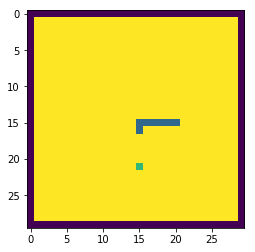

reward:  0
acted:  d
^>>>>>>>>>>>>>>>>>>>>>>>>>>>>v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^              @@@@@         v
^             @@             v
^                            v
^                            v
^                            v
^                            v
^              *             v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^<<<<<<<<<<<<<<<<<<<<<<<<<<<<v


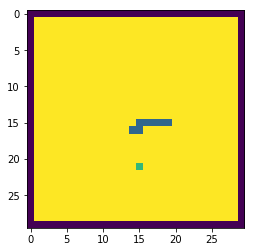

reward:  0
acted:  dl
^>>>>>>>>>>>>>>>>>>>>>>>>>>>>v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^              @@@@          v
^            @@@             v
^                            v
^                            v
^                            v
^                            v
^              *             v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^<<<<<<<<<<<<<<<<<<<<<<<<<<<<v


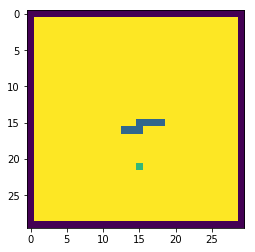

reward:  0
acted:  dl
^>>>>>>>>>>>>>>>>>>>>>>>>>>>>v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^              @@@           v
^           @@@@             v
^                            v
^                            v
^                            v
^                            v
^              *             v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^<<<<<<<<<<<<<<<<<<<<<<<<<<<<v


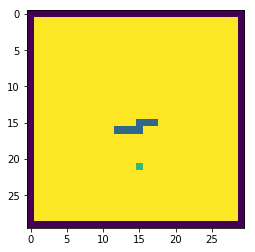

reward:  0
acted:  dll
^>>>>>>>>>>>>>>>>>>>>>>>>>>>>v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^              @@            v
^           @@@@             v
^           @                v
^                            v
^                            v
^                            v
^              *             v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^                            v
^<<<<<<<<<<<<<<<<<<<<<<<<<<<<v


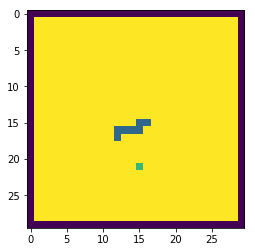

reward:  0
acted:  dlld


In [19]:
from time import sleep
snake_env = SnakeEnvironment(30,30)
import random
reward = 0
action_list = ''
for i in range(5):
    act = random.choice(range(5))
    action_list += snake_env.action_list[act] if snake_env.action_list[act] is not None else ''
    __,reward,_ = snake_env.act(act)
    snake_env.render()
    plt.imshow(snake_env.state/3.)
    plt.show()
    print('reward: ', reward)
    print('acted: ', action_list)
    sleep(1)

In [6]:
config = Config()
env = SnakeEnvironment(config.width, config.height)
agent = DQAgent(config)

In [7]:
agent.q.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 16, 26, 16)        816       
_________________________________________________________________
activation_7 (Activation)    (None, 16, 26, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 24, 32)        4640      
_________________________________________________________________
activation_8 (Activation)    (None, 14, 24, 32)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               4224      
_________________________________________________________________
activation_9 (Activation)    (None, 128)               0         
__________

In [ ]:
done = False
batch_size = 32

agent.copy_param()

for i in range(EP):
    state = env.reset()

    state = np.expand_dims(state, axis=0)
    state = np.stack([state for _ in range(2)], axis=-1)
    #print(state.shape)
    done = False
    point = 0
    for t in range(5000):
        action = agent.act(state)
        tmp_state, reward, done = env.act(action)

        next_state = np.roll(state, -1, axis=-1)
        next_state[:,:,:,-1] = tmp_state

        point += reward

        agent.remember(state, action, reward, next_state, done)
        state = next_state.copy()
        if done:
            print('episode {}/{}, score: {}'.format(i, EP, point))

            # Print counted frames
            print(t)
            agent.copy_param()
            break

    agent.replay(batch_size)
    if i % 100 == 0:
        agent.save_model('model/snake.h5')

episode 0/100000, score: -5
14
do_replay
episode 1/100000, score: -5
22
do_replay
